## Hackathon Cajamar
### Grupo OGAS
### Script predicción

# 1. Importación, funciones, lectura y primera limpieza

In [224]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [225]:
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array, 
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'), 
                  upper=s.quantile(1-limits[1], interpolation='higher'))

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
    
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/col.mad())>8
     
     # Calcular primer cuartil     
     q1 = col.quantile(0.25)  
     # Calcular tercer cuartil  
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)



# Función para calcular VCramer (dos nominales de entrada!)
def cramers_v(var1, varObj):
    if not var1.dtypes == 'category':
        #bins = min(5,var1.value_counts().count())
        var1 = pd.cut(var1, bins = 5)
    if not varObj.dtypes == 'category': #np.issubdtype(varObj, np.number):
        #bins = min(5,varObj.value_counts().count())
        varObj = pd.cut(varObj, bins = 5)
        
    data = pd.crosstab(var1, varObj).values
    vCramer = stats.contingency.association(data, method = 'cramer')
    return vCramer

## Función para histograma con boxplot 
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(9,8), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='g',linestyle='-')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data),color='y',linestyle='--')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title, xlabel="")
    # Mostrar gráfico
    plt.show()
    
## Función para gráfico de barras de variables categóricas
def cat_plot(col):
     if col.dtypes == 'category':
        fig = px.bar(col.value_counts())
        #fig = sns.countplot(x=col)
        return(fig)


## Función general plot para aplicar al archivo por columnas
def plot(col):
     if col.dtypes != 'category':
        print('Cont')
        histogram_boxplot(col, xlabel = col.name, title = 'Distibución continua')
     else:
        print('Cat')
        cat_plot(col)

In [358]:
meteo = 'DATOS_METEO.txt'
meteo = pd.read_csv(meteo, sep='|')
eto = 'DATOS_ETO.txt'
eto = pd.read_csv(eto, sep='|')
uh = 'UH_2023_TRAIN.txt'
uh = pd.read_csv(uh, sep='|')

In [227]:
na_pct = meteo.isna().mean() * 100
na_pct = na_pct[na_pct > 25] 
meteo = meteo.drop(na_pct.index, axis=1)
print(na_pct)

precip2Day             38.66
precip3Day             38.66
precip7Day             38.66
precipMtd              38.66
precipYtd              38.66
pressureMeanSeaLevel   29.10
snow2Day               38.66
snow3Day               38.66
snow7Day               38.66
snowMtd                38.66
snowSeason             38.66
snowYtd                38.66
windDirection          29.10
windGust               89.73
dtype: float64


In [228]:
na_pct = eto.isna().mean() * 100
na_pct = na_pct[na_pct > 25] 
eto = eto.drop(na_pct.index, axis=1)
print(na_pct)

EvapotranspirationLocalAfternoonAvg   67.57
EvapotranspirationLocalAfternoonMax   67.57
EvapotranspirationLocalAfternoonMin   67.57
EvapotranspirationLocalDayAvg         67.57
EvapotranspirationLocalDayMax         67.57
                                       ... 
MSLPLocalNighttimeMax                 29.27
MSLPLocalNighttimeMin                 29.27
MSLPLocalOvernightAvg                 29.27
MSLPLocalOvernightMax                 29.27
MSLPLocalOvernightMin                 29.27
Length: 84, dtype: float64


In [229]:
na_pct = uh.isna().mean() * 100
na_pct = na_pct[na_pct > 25] 
uh = uh.drop(na_pct.index, axis=1)
print(na_pct)

Series([], dtype: float64)


In [230]:
meteo

,validTimeUtc,precip1Hour,precip6Hour,precip24Hour,pressureChange,relativeHumidity,snow1Hour,snow6Hour,snow24Hour,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windSpeed,ID_ESTACION
0,2015-06-29 16:20:00,0.00,0.00,0.00,-1.40,27.00,0.00,0.00,0.00,34.50,-1.10,36.30,17.90,12.80,34.50,2.00,16.09,18.70,13
1,2015-06-29 17:20:00,0.00,0.00,0.00,-1.00,26.30,0.00,0.00,0.00,34.30,-0.40,35.00,17.90,12.30,34.30,1.00,16.09,18.00,13
2,2015-06-29 18:20:00,0.00,0.00,0.00,-0.30,29.00,0.00,0.00,0.00,32.80,0.10,34.70,17.90,12.40,32.80,0.00,16.09,16.60,13
3,2015-06-29 19:20:00,0.00,0.00,0.00,0.30,33.20,0.00,0.00,0.00,31.00,0.30,34.70,17.90,12.90,31.00,0.00,16.09,15.10,13
4,2015-06-29 20:20:00,0.00,0.00,0.00,0.90,43.10,0.00,0.00,0.00,27.60,0.00,34.70,17.90,13.90,28.00,0.00,16.09,10.10,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223655,2022-06-30 19:20:00,0.00,0.00,0.00,2.70,46.70,0.00,0.00,0.00,25.10,0.10,32.30,15.10,12.90,25.10,0.00,13.55,10.80,8
1223656,2022-06-30 20:20:00,0.00,0.00,0.00,3.70,57.10,0.00,0.00,0.00,22.90,0.20,32.30,15.10,13.90,22.90,0.00,13.59,9.00,8
1223657,2022-06-30 21:20:00,0.00,0.00,0.00,3.80,65.70,0.00,0.00,0.00,21.00,0.10,32.30,15.10,14.40,21.00,0.00,13.85,7.90,8
1223658,2022-06-30 22:20:00,0.00,0.00,0.00,3.10,75.50,0.00,0.00,0.00,19.90,0.10,32.30,15.10,15.40,19.90,0.00,13.17,8.30,8


In [231]:
meteo.describe()

,precip1Hour,precip6Hour,precip24Hour,pressureChange,relativeHumidity,snow1Hour,snow6Hour,snow24Hour,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windSpeed,ID_ESTACION
count,1223640.00,1223140.00,1223540.00,1223640.00,1223660.00,1223640.00,1223140.00,1223540.00,1223640.00,1223280.00,1223560.00,1223560.00,1223640.00,1223640.00,1223640.00,1223640.00,1223660.00,1223660.00
mean,0.07,0.36,1.43,-0.00,66.92,0.00,0.00,0.01,15.42,-0.05,21.74,10.07,8.22,14.75,1.35,12.87,10.50,9.50
std,0.59,2.19,6.02,1.13,22.12,0.04,0.16,0.41,8.01,1.51,7.94,6.08,6.04,8.81,2.35,2.88,6.86,5.77
min,0.00,0.00,0.00,-6.20,6.50,0.00,0.00,0.00,-7.90,-10.40,0.10,-7.90,-17.60,-11.30,0.00,0.10,0.00,0.00
25%,0.00,0.00,0.00,-0.80,49.60,0.00,0.00,0.00,9.30,-0.80,15.10,5.30,4.10,7.90,0.00,12.11,5.40,4.75
50%,0.00,0.00,0.00,0.00,68.40,0.00,0.00,0.00,14.70,0.10,21.00,9.70,8.20,14.20,0.00,13.48,8.60,9.50
75%,0.00,0.00,0.10,0.80,86.00,0.00,0.00,0.00,20.90,0.80,28.40,15.30,12.90,20.90,2.00,14.58,14.00,14.25
max,60.30,109.70,174.30,5.70,100.00,5.00,18.00,28.10,43.20,8.90,43.20,28.00,23.30,43.20,10.00,16.09,58.70,19.00


In [232]:
meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223660 entries, 0 to 1223659
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   validTimeUtc             1223660 non-null  object 
 1   precip1Hour              1223640 non-null  float64
 2   precip6Hour              1223140 non-null  float64
 3   precip24Hour             1223540 non-null  float64
 4   pressureChange           1223640 non-null  float64
 5   relativeHumidity         1223660 non-null  float64
 6   snow1Hour                1223640 non-null  float64
 7   snow6Hour                1223140 non-null  float64
 8   snow24Hour               1223540 non-null  float64
 9   temperature              1223640 non-null  float64
 10  temperatureChange24Hour  1223280 non-null  float64
 11  temperatureMax24Hour     1223560 non-null  float64
 12  temperatureMin24Hour     1223560 non-null  float64
 13  temperatureDewPoint      1223640 non-null 

In [233]:
eto.describe()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
count,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,...,51160.00,51160.00,51160.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00,51180.00
mean,20185595.66,280.82,281.83,279.95,281.33,283.78,278.84,281.01,282.71,279.18,...,2.72,3.66,1.92,2.51,3.92,1.59,2.21,2.67,1.77,9.50
std,20561.21,5.74,5.64,5.86,5.78,5.70,6.05,5.71,5.60,5.98,...,1.81,2.11,1.59,1.47,1.75,1.29,1.61,1.79,1.46,5.77
min,20150629.00,259.00,261.00,256.00,261.00,264.00,256.00,259.00,262.00,256.00,...,0.10,0.40,0.00,0.20,0.40,0.00,0.00,0.10,0.00,0.00
25%,20170329.00,277.00,278.00,276.00,277.00,280.00,274.70,277.00,279.00,275.00,...,1.50,2.10,0.90,1.60,2.70,0.80,1.20,1.50,0.80,4.75
50%,20181229.00,281.00,282.00,280.00,281.20,283.70,279.00,281.00,282.80,279.20,...,2.10,3.10,1.40,2.10,3.70,1.20,1.70,2.10,1.30,9.50
75%,20200929.00,285.00,286.00,284.00,286.00,288.30,283.30,285.20,287.00,283.70,...,3.50,4.60,2.50,2.90,4.70,2.00,2.70,3.20,2.20,14.25
max,20220630.00,294.80,295.40,294.30,295.00,296.40,294.00,295.00,295.80,294.20,...,13.50,15.40,12.90,15.10,16.30,12.70,15.30,16.30,13.80,19.00


In [234]:
eto

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.90,285.90,285.90,286.00,287.00,285.40,285.90,285.90,285.90,...,NaN,NaN,NaN,2.60,5.00,1.10,1.70,2.10,1.10,13
1,20150630,283.00,283.60,282.50,284.30,286.50,282.50,283.20,283.90,282.50,...,2.20,3.80,1.40,2.70,5.20,1.40,1.50,1.90,1.40,13
2,20150701,286.10,286.50,285.50,285.80,288.00,283.80,285.40,286.50,283.80,...,2.70,4.30,1.20,3.00,5.70,1.40,1.90,2.80,1.40,13
3,20150702,288.90,289.40,287.90,288.30,291.80,286.10,287.70,289.40,286.10,...,1.70,2.30,1.20,3.60,5.40,2.40,2.70,3.40,2.40,13
4,20150703,289.10,290.40,288.50,290.50,293.00,287.80,290.60,293.00,288.50,...,3.50,5.00,2.30,3.10,6.00,1.50,1.90,2.20,1.50,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51175,20220626,284.00,285.00,283.00,285.00,288.00,283.00,285.00,286.00,283.00,...,2.10,2.60,1.20,2.10,5.20,0.60,1.10,1.60,0.60,8
51176,20220627,289.00,289.00,288.00,288.00,290.00,286.00,289.00,290.00,288.00,...,3.20,3.90,2.20,3.10,5.00,1.40,1.80,2.80,1.40,8
51177,20220628,283.00,285.00,282.00,286.00,290.00,282.00,284.00,287.00,282.00,...,1.80,2.50,1.20,2.40,5.00,1.00,1.30,1.70,1.00,8
51178,20220629,283.00,285.00,282.00,285.00,288.00,282.00,284.00,286.00,282.00,...,2.20,3.10,1.30,2.70,5.40,1.30,1.60,1.90,1.30,8


In [235]:
uh

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00
...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.68,NaN
9597,22,58769,239,6,700,32,2,0,1,4.25,NaN
9598,22,58769,239,6,700,59,2,0,1,4.07,NaN
9599,22,88928,239,6,700,40,2,0,1,4.57,NaN


In [236]:
uh.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
count,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,9601.00,8526.00
mean,17.94,50818.24,498.50,12.16,45.49,1.51,0.01,0.84,0.70,9209.19
std,2.61,29016.57,261.43,4.76,23.81,0.50,0.11,0.36,1.79,13268.81
min,14.00,200.00,7.00,0.00,4.00,1.00,0.00,0.00,0.00,0.72
25%,16.00,25104.00,284.00,7.00,17.00,1.00,0.00,1.00,0.00,1940.00
50%,18.00,50946.00,464.00,12.00,52.00,2.00,0.00,1.00,0.00,4620.00
75%,20.00,76361.00,726.00,16.00,59.00,2.00,0.00,1.00,0.56,11137.50
max,22.00,99793.00,990.00,19.00,94.00,2.00,1.00,1.00,26.85,177520.00


In [237]:
uh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPAÑA      9601 non-null   int64  
 1   ID_FINCA     9601 non-null   int64  
 2   ID_ZONA      9601 non-null   int64  
 3   ID_ESTACION  9601 non-null   int64  
 4   ALTITUD      9547 non-null   object 
 5   VARIEDAD     9601 non-null   int64  
 6   MODO         9601 non-null   int64  
 7   TIPO         9601 non-null   int64  
 8   COLOR        9601 non-null   int64  
 9   SUPERFICIE   9601 non-null   float64
 10  PRODUCCION   8526 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 825.2+ KB


In [238]:
uh['CAMPAÑA']

0       14
1       14
2       14
3       14
4       14
        ..
9596    22
9597    22
9598    22
9599    22
9600    22
Name: CAMPAÑA, Length: 9601, dtype: int64

In [239]:
uh['ID_FINCA'].value_counts()

4024     59
49636    54
48827    47
84174    46
61177    36
         ..
83633     1
44142     1
81399     1
12889     1
83256     1
Name: ID_FINCA, Length: 1231, dtype: int64

In [240]:
uh['ID_ESTACION'].value_counts()

12    2060
5     1155
7     1113
16    1087
15     956
19     937
18     773
14     606
10     252
3      249
9      182
8       93
6       46
2       45
13      16
11      15
17       8
4        4
0        2
1        2
Name: ID_ESTACION, dtype: int64

In [241]:
uh.loc[uh['CAMPAÑA'] == 21]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
7482,21,48626,302,13,600,32,2,0,1,3.75,26549.05
7483,21,47921,302,13,600,32,2,0,1,7.37,52630.95
7484,21,28875,548,14,NaN,17,2,0,1,2.66,771.88
7485,21,5696,919,14,650-660,59,1,0,1,7.62,7800.00
7486,21,48093,919,14,650-660,59,2,0,1,0.00,4344.91
...,...,...,...,...,...,...,...,...,...,...,...
8521,21,37461,239,6,700,52,2,0,1,3.68,28160.10
8522,21,58769,239,6,700,32,2,0,1,4.25,41310.00
8523,21,58769,239,6,700,59,2,0,1,4.16,45420.00
8524,21,88928,239,6,700,40,2,0,1,4.75,56140.00


In [242]:
eto['date']

0        20150629
1        20150630
2        20150701
3        20150702
4        20150703
           ...   
51175    20220626
51176    20220627
51177    20220628
51178    20220629
51179    20220630
Name: date, Length: 51180, dtype: int64

In [243]:
eto['date']

0        20150629
1        20150630
2        20150701
3        20150702
4        20150703
           ...   
51175    20220626
51176    20220627
51177    20220628
51178    20220629
51179    20220630
Name: date, Length: 51180, dtype: int64

In [244]:
na_pct = meteo.isna().mean() * 100
na_pct = na_pct[na_pct > 0] 
print(na_pct)

precip1Hour               0.00
precip6Hour               0.04
precip24Hour              0.01
pressureChange            0.00
snow1Hour                 0.00
snow6Hour                 0.04
snow24Hour                0.01
temperature               0.00
temperatureChange24Hour   0.03
temperatureMax24Hour      0.01
temperatureMin24Hour      0.01
temperatureDewPoint       0.00
temperatureFeelsLike      0.00
uvIndex                   0.00
visibility                0.00
dtype: float64


In [245]:
na_pct = eto.isna().mean() * 100
na_pct = na_pct[na_pct > 0] 
print(na_pct)

DewpointLocalMorningAvg           0.04
DewpointLocalMorningMax           0.04
DewpointLocalMorningMin           0.04
FeelsLikeLocalMorningAvg          0.04
FeelsLikeLocalMorningMax          0.04
FeelsLikeLocalMorningMin          0.04
PrecipAmountLocalMorningAvg       0.04
PrecipAmountLocalMorningMax       0.04
PrecipAmountLocalMorningMin       0.04
RelativeHumidityLocalMorningAvg   0.04
RelativeHumidityLocalMorningMax   0.04
RelativeHumidityLocalMorningMin   0.04
SnowAmountLocalMorningAvg         0.04
SnowAmountLocalMorningMax         0.04
SnowAmountLocalMorningMin         0.04
TemperatureLocalMorningAvg        0.04
TemperatureLocalMorningMax        0.04
TemperatureLocalMorningMin        0.04
UVIndexLocalMorningAvg            0.04
UVIndexLocalMorningMax            0.04
UVIndexLocalMorningMin            0.04
VisibilityLocalMorningAvg         0.04
VisibilityLocalMorningMax         0.04
VisibilityLocalMorningMin         0.04
WindSpeedLocalMorningAvg          0.04
WindSpeedLocalMorningMax 

In [246]:
na_pct = uh.isna().mean() * 100
na_pct = na_pct[na_pct > 0] 
print(na_pct)

ALTITUD       0.56
PRODUCCION   11.20
dtype: float64


# 2. Unión de datasets e imputación de NAs

## 2.1. PCA Datos meteorológicos

In [247]:
eto['year'] = pd.to_datetime(eto['date'], format='%Y%m%d').dt.year
eto = eto.groupby(['year', 'ID_ESTACION']).median()
eto = eto.reset_index(level='year')
eto = eto.reset_index(level='ID_ESTACION')
eto = eto.drop(columns=['date'])
eto

,ID_ESTACION,year,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
0,0,2015,287.00,287.00,286.00,287.00,288.00,284.50,287.00,288.00,...,1.50,1.80,2.40,1.20,2.00,3.30,1.20,1.60,1.90,1.30
1,1,2015,285.00,286.00,285.00,285.00,287.00,283.00,285.00,286.50,...,1.70,1.80,2.30,1.20,2.15,3.50,1.30,1.70,2.10,1.35
2,2,2015,287.00,287.50,286.30,286.45,288.45,284.00,286.35,287.80,...,1.60,1.70,2.30,1.20,2.00,3.30,1.20,1.55,1.90,1.30
3,3,2015,286.00,287.00,286.00,286.00,288.00,284.00,286.00,287.00,...,1.65,1.70,2.30,1.30,2.10,3.40,1.20,1.70,2.10,1.30
4,4,2015,285.85,286.50,285.20,285.70,287.70,283.30,285.55,286.95,...,1.75,1.80,2.30,1.20,2.10,3.50,1.30,1.70,2.10,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,15,2022,278.00,279.00,277.00,279.00,281.00,276.00,278.00,280.00,...,1.50,2.10,3.00,1.40,2.00,3.80,1.10,1.60,2.00,1.30
156,16,2022,279.00,280.00,278.00,279.00,282.00,277.00,279.00,281.00,...,1.40,1.80,2.80,1.20,1.80,3.60,0.90,1.30,1.80,1.00
157,17,2022,277.00,278.00,276.00,278.00,280.00,275.00,278.00,279.00,...,1.70,2.20,3.40,1.50,2.20,4.10,1.20,1.80,2.10,1.30
158,18,2022,279.20,280.20,278.20,279.60,281.60,277.30,279.40,280.80,...,1.40,1.80,2.60,1.20,1.80,3.10,1.00,1.50,1.90,1.10


In [248]:
meteo['year'] = pd.to_datetime(meteo['validTimeUtc'], format="%Y-%m-%d %H:%M:%S").dt.year
meteo = meteo.groupby(['year', 'ID_ESTACION']).median()
meteo = meteo.reset_index(level='year')
meteo = meteo.reset_index(level='ID_ESTACION')
meteo

,ID_ESTACION,year,precip1Hour,precip6Hour,precip24Hour,pressureChange,relativeHumidity,snow1Hour,snow6Hour,snow24Hour,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windSpeed
0,0,2015,0.00,0.00,0.00,0.00,78.60,0.00,0.00,0.00,18.40,-0.10,24.30,13.70,13.60,18.40,0.00,16.09,6.80
1,1,2015,0.00,0.00,0.00,0.00,78.10,0.00,0.00,0.00,17.30,-0.10,23.00,12.30,12.20,17.25,0.00,16.09,7.60
2,2,2015,0.00,0.00,0.00,0.00,81.60,0.00,0.00,0.00,17.80,-0.10,24.70,12.60,13.50,17.80,0.00,16.09,6.80
3,3,2015,0.00,0.00,0.00,0.00,80.30,0.00,0.00,0.00,18.00,-0.20,24.60,13.30,13.20,18.00,0.00,16.09,7.20
4,4,2015,0.00,0.00,0.00,0.00,78.10,0.00,0.00,0.00,17.70,0.00,23.70,12.20,12.80,17.70,0.00,16.09,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,15,2022,0.00,0.00,0.00,0.00,66.00,0.00,0.00,0.00,10.80,0.00,16.70,7.40,5.60,9.60,0.00,12.77,9.00
156,16,2022,0.00,0.00,0.00,0.00,67.30,0.00,0.00,0.00,11.10,0.00,17.20,7.40,5.90,10.10,0.00,12.86,7.90
157,17,2022,0.00,0.00,0.00,0.00,65.00,0.00,0.00,0.00,10.10,0.10,16.20,6.50,4.60,8.80,0.00,12.75,9.70
158,18,2022,0.00,0.00,0.00,0.00,66.70,0.00,0.00,0.00,11.20,0.00,17.50,7.70,6.30,10.20,0.00,12.86,7.60


In [249]:
met = eto.merge(meteo, on=['year', 'ID_ESTACION'], how='left')
#met = met.set_index('year')
met

,ID_ESTACION,year,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,...,snow24Hour,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windSpeed
0,0,2015,287.00,287.00,286.00,287.00,288.00,284.50,287.00,288.00,...,0.00,18.40,-0.10,24.30,13.70,13.60,18.40,0.00,16.09,6.80
1,1,2015,285.00,286.00,285.00,285.00,287.00,283.00,285.00,286.50,...,0.00,17.30,-0.10,23.00,12.30,12.20,17.25,0.00,16.09,7.60
2,2,2015,287.00,287.50,286.30,286.45,288.45,284.00,286.35,287.80,...,0.00,17.80,-0.10,24.70,12.60,13.50,17.80,0.00,16.09,6.80
3,3,2015,286.00,287.00,286.00,286.00,288.00,284.00,286.00,287.00,...,0.00,18.00,-0.20,24.60,13.30,13.20,18.00,0.00,16.09,7.20
4,4,2015,285.85,286.50,285.20,285.70,287.70,283.30,285.55,286.95,...,0.00,17.70,0.00,23.70,12.20,12.80,17.70,0.00,16.09,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,15,2022,278.00,279.00,277.00,279.00,281.00,276.00,278.00,280.00,...,0.00,10.80,0.00,16.70,7.40,5.60,9.60,0.00,12.77,9.00
156,16,2022,279.00,280.00,278.00,279.00,282.00,277.00,279.00,281.00,...,0.00,11.10,0.00,17.20,7.40,5.90,10.10,0.00,12.86,7.90
157,17,2022,277.00,278.00,276.00,278.00,280.00,275.00,278.00,279.00,...,0.00,10.10,0.10,16.20,6.50,4.60,8.80,0.00,12.75,9.70
158,18,2022,279.20,280.20,278.20,279.60,281.60,277.30,279.40,280.80,...,0.00,11.20,0.00,17.50,7.70,6.30,10.20,0.00,12.86,7.60


In [250]:
zero_percentages = met.eq(0).mean()

# filter columns where percentage of 0s is greater than 0.95
drop_cols = zero_percentages[zero_percentages > 0.95].index

# drop filtered columns from DataFrame
met = met.drop(drop_cols, axis=1)

print(drop_cols)

Index(['PrecipAmountLocalAfternoonAvg', 'PrecipAmountLocalAfternoonMax',
       'PrecipAmountLocalAfternoonMin', 'PrecipAmountLocalDayAvg',
       'PrecipAmountLocalDayMax', 'PrecipAmountLocalDayMin',
       'PrecipAmountLocalDaytimeAvg', 'PrecipAmountLocalDaytimeMax',
       'PrecipAmountLocalDaytimeMin', 'PrecipAmountLocalEveningAvg',
       'PrecipAmountLocalEveningMax', 'PrecipAmountLocalEveningMin',
       'PrecipAmountLocalMorningAvg', 'PrecipAmountLocalMorningMax',
       'PrecipAmountLocalMorningMin', 'PrecipAmountLocalNighttimeAvg',
       'PrecipAmountLocalNighttimeMax', 'PrecipAmountLocalNighttimeMin',
       'PrecipAmountLocalOvernightAvg', 'PrecipAmountLocalOvernightMax',
       'PrecipAmountLocalOvernightMin', 'SnowAmountLocalAfternoonAvg',
       'SnowAmountLocalAfternoonMax', 'SnowAmountLocalAfternoonMin',
       'SnowAmountLocalDayAvg', 'SnowAmountLocalDayMax',
       'SnowAmountLocalDayMin', 'SnowAmountLocalDaytimeAvg',
       'SnowAmountLocalDaytimeMax', 'SnowAmountL

In [251]:
met

,ID_ESTACION,year,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,...,pressureChange,relativeHumidity,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,visibility,windSpeed
0,0,2015,287.00,287.00,286.00,287.00,288.00,284.50,287.00,288.00,...,0.00,78.60,18.40,-0.10,24.30,13.70,13.60,18.40,16.09,6.80
1,1,2015,285.00,286.00,285.00,285.00,287.00,283.00,285.00,286.50,...,0.00,78.10,17.30,-0.10,23.00,12.30,12.20,17.25,16.09,7.60
2,2,2015,287.00,287.50,286.30,286.45,288.45,284.00,286.35,287.80,...,0.00,81.60,17.80,-0.10,24.70,12.60,13.50,17.80,16.09,6.80
3,3,2015,286.00,287.00,286.00,286.00,288.00,284.00,286.00,287.00,...,0.00,80.30,18.00,-0.20,24.60,13.30,13.20,18.00,16.09,7.20
4,4,2015,285.85,286.50,285.20,285.70,287.70,283.30,285.55,286.95,...,0.00,78.10,17.70,0.00,23.70,12.20,12.80,17.70,16.09,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,15,2022,278.00,279.00,277.00,279.00,281.00,276.00,278.00,280.00,...,0.00,66.00,10.80,0.00,16.70,7.40,5.60,9.60,12.77,9.00
156,16,2022,279.00,280.00,278.00,279.00,282.00,277.00,279.00,281.00,...,0.00,67.30,11.10,0.00,17.20,7.40,5.90,10.10,12.86,7.90
157,17,2022,277.00,278.00,276.00,278.00,280.00,275.00,278.00,279.00,...,0.00,65.00,10.10,0.10,16.20,6.50,4.60,8.80,12.75,9.70
158,18,2022,279.20,280.20,278.20,279.60,281.60,277.30,279.40,280.80,...,0.00,66.70,11.20,0.00,17.50,7.70,6.30,10.20,12.86,7.60


In [252]:
# mantenemos ID_ESTACION sin PCA
keep_cols = ['ID_ESTACION', 'year']
keep = met[['ID_ESTACION', 'year']]
met = met.drop(keep_cols, axis=1)

In [253]:
met

,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,DewpointLocalEveningAvg,...,pressureChange,relativeHumidity,temperature,temperatureChange24Hour,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,visibility,windSpeed
0,287.00,287.00,286.00,287.00,288.00,284.50,287.00,288.00,285.00,287.00,...,0.00,78.60,18.40,-0.10,24.30,13.70,13.60,18.40,16.09,6.80
1,285.00,286.00,285.00,285.00,287.00,283.00,285.00,286.50,283.50,286.00,...,0.00,78.10,17.30,-0.10,23.00,12.30,12.20,17.25,16.09,7.60
2,287.00,287.50,286.30,286.45,288.45,284.00,286.35,287.80,284.40,287.20,...,0.00,81.60,17.80,-0.10,24.70,12.60,13.50,17.80,16.09,6.80
3,286.00,287.00,286.00,286.00,288.00,284.00,286.00,287.00,284.00,287.00,...,0.00,80.30,18.00,-0.20,24.60,13.30,13.20,18.00,16.09,7.20
4,285.85,286.50,285.20,285.70,287.70,283.30,285.55,286.95,283.60,286.50,...,0.00,78.10,17.70,0.00,23.70,12.20,12.80,17.70,16.09,7.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,278.00,279.00,277.00,279.00,281.00,276.00,278.00,280.00,277.00,279.00,...,0.00,66.00,10.80,0.00,16.70,7.40,5.60,9.60,12.77,9.00
156,279.00,280.00,278.00,279.00,282.00,277.00,279.00,281.00,277.00,280.00,...,0.00,67.30,11.10,0.00,17.20,7.40,5.90,10.10,12.86,7.90
157,277.00,278.00,276.00,278.00,280.00,275.00,278.00,279.00,276.00,278.00,...,0.00,65.00,10.10,0.10,16.20,6.50,4.60,8.80,12.75,9.70
158,279.20,280.20,278.20,279.60,281.60,277.30,279.40,280.80,278.00,280.20,...,0.00,66.70,11.20,0.00,17.50,7.70,6.30,10.20,12.86,7.60


In [254]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler = StandardScaler()
met = scaler.fit_transform(met)
print(met)

[[ 2.54332898  2.35644199  2.38576367 ...  2.08537123  1.66661712
  -1.75812428]
 [ 1.65381013  1.87393531  1.95712723 ...  1.52647777  1.66661712
  -1.03007541]
 [ 2.54332898  2.59769532  2.51435461 ...  1.79377464  1.66661712
  -1.75812428]
 ...
 [-1.90426528 -1.98611811 -1.9006008  ... -2.5801742  -0.87785103
   0.8810529 ]
 [-0.92579454 -0.92460342 -0.95760061 ... -1.89978215 -0.79405119
  -1.03007541]
 [-0.569987   -0.53859808 -1.0433279  ... -1.5109867  -0.81690569
  -0.75705708]]


In [255]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
print(f"""
El valor del test de esfericidad de Barlett es: {calculate_bartlett_sphericity(met)[0]}
Y su p-valor es: {calculate_bartlett_sphericity(met)[1]}
----------------------------------------------------------------------------------------------------
El valor del índice KMO es: {calculate_kmo(met)[1]}""")
# muy alto


El valor del test de esfericidad de Barlett es: inf
Y su p-valor es: 0.0
----------------------------------------------------------------------------------------------------
El valor del índice KMO es: 0.8955936784520129


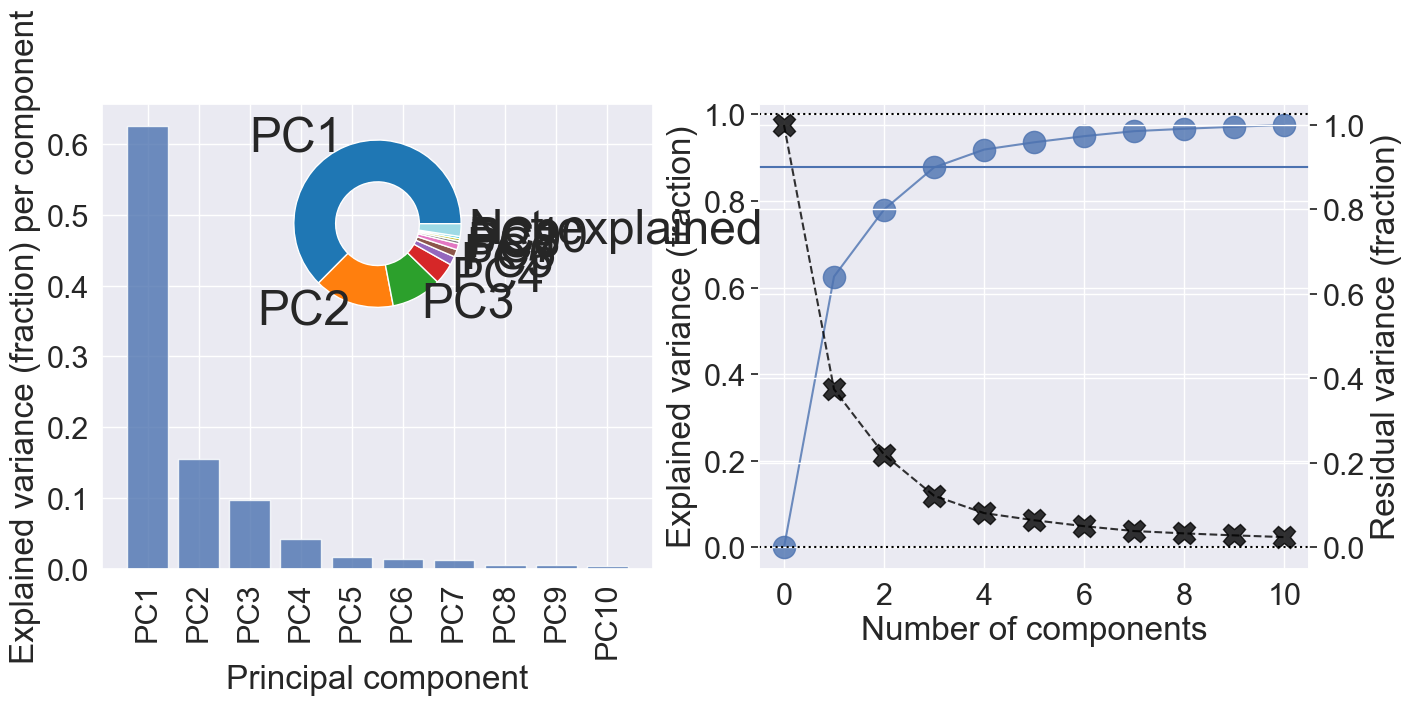

In [256]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
scores = pca.fit_transform(met)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from psynlig import (
    pca_explained_variance,
    pca_residual_variance,
    pca_explained_variance_bar,
    pca_explained_variance_pie,
    pca_1d_loadings,
    pca_2d_loadings,
    pca_2d_scores
)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True
)
pca_explained_variance_bar(pca, axi=ax1, alpha=0.8)
pca_explained_variance(pca, axi=ax2, marker='o', markersize=16, alpha=0.8)
ax4 = ax2.twinx()
pca_residual_variance(
    pca,
    ax4,
    marker='X',
    markersize=16,
    alpha=0.8,
    color='black',
    linestyle='--'
)
plt.axhline(y=0.9)
ax3 = inset_axes(ax1, width='45%', height='45%', loc=9)
pca_explained_variance_pie(pca, axi=ax3, cmap='tab20')
plt.show()


In [257]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(met)

# create a new DataFrame with PCA components and the kept column
met = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])
met[keep_cols] = keep

print(met)

       PC1   PC2  PC3  ID_ESTACION  year
0    22.87 -1.18 2.94            0  2015
1    17.57  1.69 2.36            1  2015
2    22.22 -0.89 1.84            2  2015
3    21.35  0.86 2.87            3  2015
4    19.33  0.41 0.70            4  2015
..     ...   ...  ...          ...   ...
155 -15.46  2.85 7.01           15  2022
156 -13.41  0.56 8.21           16  2022
157 -19.50  5.74 6.00           17  2022
158 -12.29 -1.57 9.67           18  2022
159 -10.15 -0.90 7.42           19  2022

[160 rows x 5 columns]


In [258]:
met.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x,clas='winsor'))
# no hay outliers > 3IQR o < -3IQR

PC1
PC2
PC3
ID_ESTACION
year


,PC1,PC2,PC3,ID_ESTACION,year
0,22.87,-1.18,2.94,0,2015
1,17.57,1.69,2.36,1,2015
2,22.22,-0.89,1.84,2,2015
3,21.35,0.86,2.87,3,2015
4,19.33,0.41,0.70,4,2015
...,...,...,...,...,...
155,-15.46,2.85,7.01,15,2022
156,-13.41,0.56,8.21,16,2022
157,-19.50,5.74,6.00,17,2022
158,-12.29,-1.57,9.67,18,2022


## 2.2. Datos de fincas y dataframe completo

In [259]:
uh

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00
...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.68,NaN
9597,22,58769,239,6,700,32,2,0,1,4.25,NaN
9598,22,58769,239,6,700,59,2,0,1,4.07,NaN
9599,22,88928,239,6,700,40,2,0,1,4.57,NaN


In [260]:
#uh = uh.dropna()
uh['year'] = uh['CAMPAÑA'].apply(lambda x: datetime.strptime(str(x), '%y'))
uh['year'] = pd.to_datetime(uh['year'], format='%Y%m%d').dt.year
uh = uh.drop(columns=['CAMPAÑA'])
uh = uh.sort_values(by='ID_FINCA')
uh
#uh = uh.groupby(['year', 'ID_ESTACION']).median()
#uh = uh.reset_index(level='year')
#uh = uh.reset_index(level='ID_ESTACION')

,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year
1819,200,86,12,475-490,59,1,0,1,0.00,778.10,2015
671,200,86,12,475-490,59,1,0,1,0.00,1900.00,2014
5037,200,86,12,475-490,59,1,0,1,0.00,607.21,2018
2915,200,86,12,475-490,59,1,0,1,0.00,1636.20,2016
6109,200,86,12,475-490,59,1,0,1,0.00,392.69,2019
...,...,...,...,...,...,...,...,...,...,...,...
1254,99693,899,16,640,81,1,0,1,0.00,14480.84,2015
5522,99693,899,16,640,81,1,0,1,0.00,18405.39,2019
8655,99693,899,16,640,81,1,0,1,6.34,NaN,2022
8539,99793,919,14,650-660,87,2,0,0,0.02,NaN,2022


In [261]:
for col in ['ID_ZONA', 'TIPO', 'COLOR', 'MODO', 'VARIEDAD', 'ID_FINCA']:
    print(uh[col].unique())
    uh[col] = uh[col].astype('object')
    
#uh['ID_FINCA'] = uh['ID_FINCA'].astype('object')

[ 86 468 757 272 839 473 449 845 698 585 464 441 412 474 510 732 885 849
 559 284 513 737 990 379 677 919 462 759 123 134 384 209  64 266  36 724
 408 715 803 700 669  44 337 899 726 751 170 893 653 501 292 299 252 616
  47 301 592 144 772 215 784 428 939   7 816 353 852 506 639 307 100 355
 165 417 254 389 401 987 973 373 672 846 142 605 983 871 619 548 804 862
 831 964 881 186 239 511  82 349 203 966 302 828 836 848 233 734  71  50
  74 601 126 439  52 844 938 340  62  41 515  56 898 388 200 411 602]
[0 1]
[1 0]
[1 2]
[59  9 52 17 40 32 81 68 94 15 26 87 23 65 43 55 92 84 62  4 71 48  8 38
 10]
[  200   439   447 ... 99377 99693 99793]


In [262]:
uh['ALTITUD'].unique()

array(['475-490', '570-640', '460-480', '600-670', '610', '450-480',
       '550-700', '625-670', '480-500', '570-580', '650-660', '455-470',
       '580-630', '620-630', '560-640', '550-630', '500-700', '680-720',
       '700', '630-670', '610-635', '620-640', '650-680', '610-630',
       '500-550', '480', '500-530', '455-465', '550', '540-570',
       '630-640', '600-620', '660', '600-630', '600-610', '645-660',
       '640', '580-600', '635', '460-500', nan, '440-450', '650',
       '520-540', '470-500', '820', '600-640', '525', '370', '730',
       '605-615', '415-425', '385', '590-600', '500', '655', '660-680',
       '640-690', '470', '520-530', '670', '390', '480-490', '565',
       '390-450', '550-610', '510-530', '480-520', '445', '695', '620',
       '445-465', '380-395', '430-470', '600', '440', '530', '750',
       '555-580', '550-570', '690', '510', '570', '520', '800'],
      dtype=object)

In [263]:
# función para convertir altitud a int
def str_to_mean(s):
    if pd.isna(s):
        return s
    elif '-' in s:
        x, y = map(float, s.split('-'))
        return (x + y) / 2
    else:
        return float(s)
    
uh['ALTITUD'] = uh['ALTITUD'].apply(str_to_mean)

In [264]:
uh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601 entries, 1819 to 8540
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID_FINCA     9601 non-null   object 
 1   ID_ZONA      9601 non-null   object 
 2   ID_ESTACION  9601 non-null   int64  
 3   ALTITUD      9547 non-null   float64
 4   VARIEDAD     9601 non-null   object 
 5   MODO         9601 non-null   object 
 6   TIPO         9601 non-null   object 
 7   COLOR        9601 non-null   object 
 8   SUPERFICIE   9601 non-null   float64
 9   PRODUCCION   8526 non-null   float64
 10  year         9601 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 900.1+ KB


In [265]:
uh

,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year
1819,200,86,12,482.50,59,1,0,1,0.00,778.10,2015
671,200,86,12,482.50,59,1,0,1,0.00,1900.00,2014
5037,200,86,12,482.50,59,1,0,1,0.00,607.21,2018
2915,200,86,12,482.50,59,1,0,1,0.00,1636.20,2016
6109,200,86,12,482.50,59,1,0,1,0.00,392.69,2019
...,...,...,...,...,...,...,...,...,...,...,...
1254,99693,899,16,640.00,81,1,0,1,0.00,14480.84,2015
5522,99693,899,16,640.00,81,1,0,1,0.00,18405.39,2019
8655,99693,899,16,640.00,81,1,0,1,6.34,NaN,2022
8539,99793,919,14,655.00,87,2,0,0,0.02,NaN,2022


In [266]:
na_pct = uh.isna().mean() * 100
na_pct = na_pct[na_pct > 0] 
print(na_pct)

ALTITUD       0.56
PRODUCCION   11.20
dtype: float64


In [267]:
na_rows = uh.loc[uh['ALTITUD'].isna(), ['ALTITUD', 'year']]

print(na_rows)

      ALTITUD  year
3934      NaN  2017
3935      NaN  2017
8122      NaN  2021
8121      NaN  2021
6075      NaN  2019
9174      NaN  2022
9175      NaN  2022
7102      NaN  2020
5006      NaN  2018
7103      NaN  2020
6076      NaN  2019
5005      NaN  2018
2267      NaN  2016
1153      NaN  2015
3345      NaN  2017
7         NaN  2014
4         NaN  2014
1150      NaN  2015
1151      NaN  2015
5         NaN  2014
11        NaN  2014
4362      NaN  2018
7484      NaN  2021
1157      NaN  2015
6338      NaN  2019
1219      NaN  2015
2336      NaN  2016
75        NaN  2014
10        NaN  2014
9         NaN  2014
1156      NaN  2015
1155      NaN  2015
3489      NaN  2017
4512      NaN  2018
7457      NaN  2020
7348      NaN  2020
8385      NaN  2021
6339      NaN  2019
9433      NaN  2022
8120      NaN  2021
9173      NaN  2022
6074      NaN  2019
9172      NaN  2022
6073      NaN  2019
5003      NaN  2018
7100      NaN  2020
7101      NaN  2020
8119      NaN  2021
5004      NaN  2018


In [268]:
df = uh.merge(met, on=['ID_ESTACION', 'year'], how='left')
df = df.drop(columns=['ID_ESTACION'])
df

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
0,200,86,482.50,59,1,0,1,0.00,778.10,2015,22.09,-0.51,2.15
1,200,86,482.50,59,1,0,1,0.00,1900.00,2014,NaN,NaN,NaN
2,200,86,482.50,59,1,0,1,0.00,607.21,2018,-0.89,2.31,-4.85
3,200,86,482.50,59,1,0,1,0.00,1636.20,2016,5.65,7.31,0.05
4,200,86,482.50,59,1,0,1,0.00,392.69,2019,-2.69,-1.38,-4.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,99693,899,640.00,81,1,0,1,0.00,14480.84,2015,21.75,0.79,3.21
9597,99693,899,640.00,81,1,0,1,0.00,18405.39,2019,-4.56,-2.71,-1.27
9598,99693,899,640.00,81,1,0,1,6.34,NaN,2022,-13.41,0.56,8.21
9599,99793,919,655.00,87,2,0,0,0.02,NaN,2022,-17.55,3.95,7.57


In [269]:
df.describe()

,ALTITUD,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
count,9547.00,9601.00,8526.00,9601.00,8453.00,8453.00,8453.00
mean,577.85,0.70,9209.19,2017.94,0.80,-0.12,0.21
std,76.49,1.79,13268.81,2.61,9.44,4.25,3.69
min,370.00,0.00,0.72,2014.00,-17.55,-9.62,-5.82
25%,490.00,0.00,1940.00,2016.00,-3.87,-3.01,-2.91
50%,610.00,0.00,4620.00,2018.00,-1.26,-0.51,-0.39
75%,635.00,0.56,11137.50,2020.00,3.40,1.38,2.17
max,820.00,26.85,177520.00,2022.00,24.48,10.73,9.67


In [270]:
# Una superficie de 0 es literalmente una contradicción en términos, probablemente se trate de perdidos. Vamos a ver cuántos hay:

zero_percentages = df.eq(0).mean()

drop_cols = zero_percentages[zero_percentages > 0.50].index

print(drop_cols)
# La superficie es una variable muy relevante para la producción... pero inventarnos tantos datos sería peligroso.. vamos a probar si el resultado es razonable

Index(['TIPO', 'SUPERFICIE'], dtype='object')


In [271]:
df

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
0,200,86,482.50,59,1,0,1,0.00,778.10,2015,22.09,-0.51,2.15
1,200,86,482.50,59,1,0,1,0.00,1900.00,2014,NaN,NaN,NaN
2,200,86,482.50,59,1,0,1,0.00,607.21,2018,-0.89,2.31,-4.85
3,200,86,482.50,59,1,0,1,0.00,1636.20,2016,5.65,7.31,0.05
4,200,86,482.50,59,1,0,1,0.00,392.69,2019,-2.69,-1.38,-4.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,99693,899,640.00,81,1,0,1,0.00,14480.84,2015,21.75,0.79,3.21
9597,99693,899,640.00,81,1,0,1,0.00,18405.39,2019,-4.56,-2.71,-1.27
9598,99693,899,640.00,81,1,0,1,6.34,NaN,2022,-13.41,0.56,8.21
9599,99793,919,655.00,87,2,0,0,0.02,NaN,2022,-17.55,3.95,7.57


In [272]:
a = df.loc[df['year'].isin([2020, 2021, 2022]), ['ID_FINCA', 'SUPERFICIE', 'year']].groupby(['ID_FINCA', 'year']).mean()
a
# observamos que la variación es nula o muy pequeña, no es problemático inferir los perdidos -asumiendo que se comportan igual, lo que es comprensible

SUPERFICIE
ID_FINCA year            
200      2020        0.37
439      2021        1.08
         2022        1.08
447      2020        0.47
         2021        0.47
...                   ...
99377    2022        0.65
99693    2020        6.35
         2021        6.35
         2022        6.34
99793    2022        0.08

[2408 rows x 1 columns]

In [273]:
df['SUPERFICIE'] = df['SUPERFICIE'].replace(0, np.nan)
df

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
0,200,86,482.50,59,1,0,1,NaN,778.10,2015,22.09,-0.51,2.15
1,200,86,482.50,59,1,0,1,NaN,1900.00,2014,NaN,NaN,NaN
2,200,86,482.50,59,1,0,1,NaN,607.21,2018,-0.89,2.31,-4.85
3,200,86,482.50,59,1,0,1,NaN,1636.20,2016,5.65,7.31,0.05
4,200,86,482.50,59,1,0,1,NaN,392.69,2019,-2.69,-1.38,-4.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9596,99693,899,640.00,81,1,0,1,NaN,14480.84,2015,21.75,0.79,3.21
9597,99693,899,640.00,81,1,0,1,NaN,18405.39,2019,-4.56,-2.71,-1.27
9598,99693,899,640.00,81,1,0,1,6.34,NaN,2022,-13.41,0.56,8.21
9599,99793,919,655.00,87,2,0,0,0.02,NaN,2022,-17.55,3.95,7.57


In [274]:
# es necesario para que el ffill na tenga sentido
df = df.sort_values(by=['ID_FINCA', 'year'])
df

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
1,200,86,482.50,59,1,0,1,NaN,1900.00,2014,NaN,NaN,NaN
0,200,86,482.50,59,1,0,1,NaN,778.10,2015,22.09,-0.51,2.15
3,200,86,482.50,59,1,0,1,NaN,1636.20,2016,5.65,7.31,0.05
5,200,86,482.50,59,1,0,1,NaN,829.01,2017,2.16,-2.06,-5.10
2,200,86,482.50,59,1,0,1,NaN,607.21,2018,-0.89,2.31,-4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,99693,899,640.00,81,1,0,1,6.35,26876.30,2020,-2.10,-5.85,1.82
9594,99693,899,640.00,81,1,0,1,6.35,35418.70,2021,-3.09,-3.99,-1.01
9598,99693,899,640.00,81,1,0,1,6.34,NaN,2022,-13.41,0.56,8.21
9599,99793,919,655.00,87,2,0,0,0.02,NaN,2022,-17.55,3.95,7.57


### 2.3. Primero enconding para variables categóricas. Después imputación de perdidos por bfill.

In [275]:
# encoding por la mediana
def target_encode(df, col, target_col):
    agg = df.groupby(col)[target_col].agg(['median', 'count'])
    smoothing = 100
    prior = df[target_col].median()
    encoded = ((agg['median'] * agg['count']) + (prior * smoothing)) / (agg['count'] + smoothing)
    return encoded

# seleccionamos esto para que no aparezcan na en la target
df21 = df.loc[~(df.year == 2022)]

# targeting
for col in ['VARIEDAD', 'ID_ZONA']:
    encoded = target_encode(df21, col, 'PRODUCCION')
    df21[col+'_target_encoded'] = df21[col].map(encoded)
    
# mapeo en df entero con 2022 de categorías originales con la mediana del encoding
median_encoding = df21.groupby(['VARIEDAD', 'ID_ZONA'], as_index=False).median()[['VARIEDAD', 'ID_ZONA', 'VARIEDAD_target_encoded', 'ID_ZONA_target_encoded']]

df['VARIEDAD'] = df['VARIEDAD'].map(median_encoding['VARIEDAD_target_encoded'])
df['ID_ZONA'] = df['ID_ZONA'].map(median_encoding['ID_ZONA_target_encoded'])
df

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3
1,200,4876.86,482.50,3375.06,1,0,1,NaN,1900.00,2014,NaN,NaN,NaN
0,200,4876.86,482.50,3375.06,1,0,1,NaN,778.10,2015,22.09,-0.51,2.15
3,200,4876.86,482.50,3375.06,1,0,1,NaN,1636.20,2016,5.65,7.31,0.05
5,200,4876.86,482.50,3375.06,1,0,1,NaN,829.01,2017,2.16,-2.06,-5.10
2,200,4876.86,482.50,3375.06,1,0,1,NaN,607.21,2018,-0.89,2.31,-4.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,99693,NaN,640.00,3375.06,1,0,1,6.35,26876.30,2020,-2.10,-5.85,1.82
9594,99693,NaN,640.00,3375.06,1,0,1,6.35,35418.70,2021,-3.09,-3.99,-1.01
9598,99693,NaN,640.00,3375.06,1,0,1,6.34,NaN,2022,-13.41,0.56,8.21
9599,99793,NaN,655.00,3375.06,2,0,0,0.02,NaN,2022,-17.55,3.95,7.57


### 2.4. Producción laggeada

In [276]:
# group by ID and shift values
df['PRODUCCION_lag'] = df.groupby('ID_FINCA')['PRODUCCION'].shift(1)

# replace NaN values with 0 for the first year
#df['PRODUCCION_lag'].fillna(0, inplace=True)

df.head()

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,year,PC1,PC2,PC3,PRODUCCION_lag
1,200,4876.86,482.50,3375.06,1,0,1,NaN,1900.00,2014,NaN,NaN,NaN,NaN
0,200,4876.86,482.50,3375.06,1,0,1,NaN,778.10,2015,22.09,-0.51,2.15,1900.00
3,200,4876.86,482.50,3375.06,1,0,1,NaN,1636.20,2016,5.65,7.31,0.05,778.10
5,200,4876.86,482.50,3375.06,1,0,1,NaN,829.01,2017,2.16,-2.06,-5.10,1636.20
2,200,4876.86,482.50,3375.06,1,0,1,NaN,607.21,2018,-0.89,2.31,-4.85,829.01


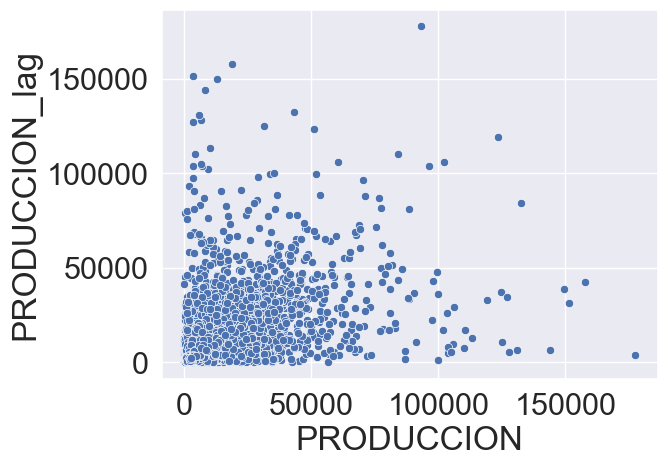

In [277]:
sns.scatterplot(df['PRODUCCION'], df['PRODUCCION_lag']);

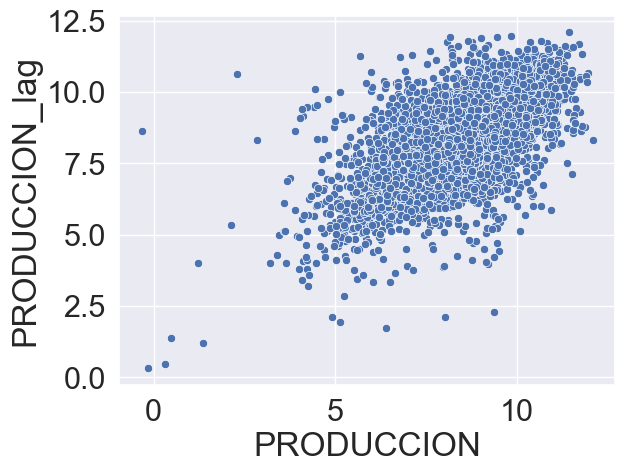

In [278]:
sns.scatterplot(np.log(df['PRODUCCION']), np.log(df['PRODUCCION_lag']));

In [279]:
df['PRODUCCION'].isna().sum()

1075

In [280]:
from sklearn.linear_model import LinearRegression

# fill missing values with median of their respective year
X = np.log(df.loc[(df['year'] != 2014) & (df['year'] != 2022), 'PRODUCCION_lag'].fillna(np.median(df['PRODUCCION_lag'].dropna())))


Y = np.log(df.loc[(df['year'] != 2014) & (df['year'] != 2022), 'PRODUCCION'])

# Step 1: Filter rows with non-missing values in both columns

#
## Step 3: Fit a linear regression model
model = LinearRegression().fit(Y.values.reshape(-1,1), X)

# Step 4: Use the fitted model to predict missing values
df.loc[(df['year'] != 2022) & df['PRODUCCION_lag'].isna(), 'PRODUCCION_lag'] = np.exp(model.predict(np.log(df.loc[(df['year'] != 2022) & df['PRODUCCION_lag'].isna(), 'PRODUCCION']).values.reshape(-1, 1)))


In [281]:
df['PRODUCCION_lag'].isna().sum()

288

In [282]:
median_2022 = df.loc[df['year'] == 2022, 'PRODUCCION_lag'].median()

# fill missing values in PRODUCCION_lag with median of 2022
df['PRODUCCION_lag'].fillna(median_2022, inplace=True)

In [283]:
df['PRODUCCION_lag'].isna().sum()

0

In [284]:
#df['year'] = pd.to_datetime(df['year'], format='%Y')
#df = df.sample(1000)
dfy = df[['year', 'PRODUCCION']]
dfx = df.loc[:, ~df.columns.isin(['PRODUCCION'])]

In [285]:
dfx.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x,clas='winsor'))

ID_ZONA
ALTITUD
VARIEDAD
SUPERFICIE
year
PC1
PC2
PC3
PRODUCCION_lag


,ID_ZONA,ALTITUD,VARIEDAD,SUPERFICIE,year,PC1,PC2,PC3,PRODUCCION_lag
1,4876.86,482.50,3375.06,NaN,2014,NaN,NaN,NaN,2557.73
0,4876.86,482.50,3375.06,NaN,2015,22.09,-0.51,2.15,1900.00
3,4876.86,482.50,3375.06,NaN,2016,5.65,7.31,0.05,778.10
5,4876.86,482.50,3375.06,NaN,2017,2.16,-2.06,-5.10,1636.20
2,4876.86,482.50,3375.06,NaN,2018,-0.89,2.31,-4.85,829.01
...,...,...,...,...,...,...,...,...,...
9595,NaN,640.00,3375.06,6.35,2020,-2.10,-5.85,1.82,18405.39
9594,NaN,640.00,3375.06,6.35,2021,-3.09,-3.99,-1.01,26876.30
9598,NaN,640.00,3375.06,6.34,2022,-13.41,0.56,8.21,35418.70
9599,NaN,655.00,3375.06,0.02,2022,-17.55,3.95,7.57,4391.69


In [286]:
for i in dfx.select_dtypes(include=np.number).columns:
    dfx[i]= dfx[i].fillna(method='bfill')
dfx

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,year,PC1,PC2,PC3,PRODUCCION_lag
1,200,4876.86,482.50,3375.06,1,0,1,0.37,2014,22.09,-0.51,2.15,2557.73
0,200,4876.86,482.50,3375.06,1,0,1,0.37,2015,22.09,-0.51,2.15,1900.00
3,200,4876.86,482.50,3375.06,1,0,1,0.37,2016,5.65,7.31,0.05,778.10
5,200,4876.86,482.50,3375.06,1,0,1,0.37,2017,2.16,-2.06,-5.10,1636.20
2,200,4876.86,482.50,3375.06,1,0,1,0.37,2018,-0.89,2.31,-4.85,829.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,99693,NaN,640.00,3375.06,1,0,1,6.35,2020,-2.10,-5.85,1.82,18405.39
9594,99693,NaN,640.00,3375.06,1,0,1,6.35,2021,-3.09,-3.99,-1.01,26876.30
9598,99693,NaN,640.00,3375.06,1,0,1,6.34,2022,-13.41,0.56,8.21,35418.70
9599,99793,NaN,655.00,3375.06,2,0,0,0.02,2022,-17.55,3.95,7.57,4391.69


### 2.5. Quedan algunos perdidos, vamos a ver la distribución a ver como los ajustamos y si hacemos algún otro cambio

Cont


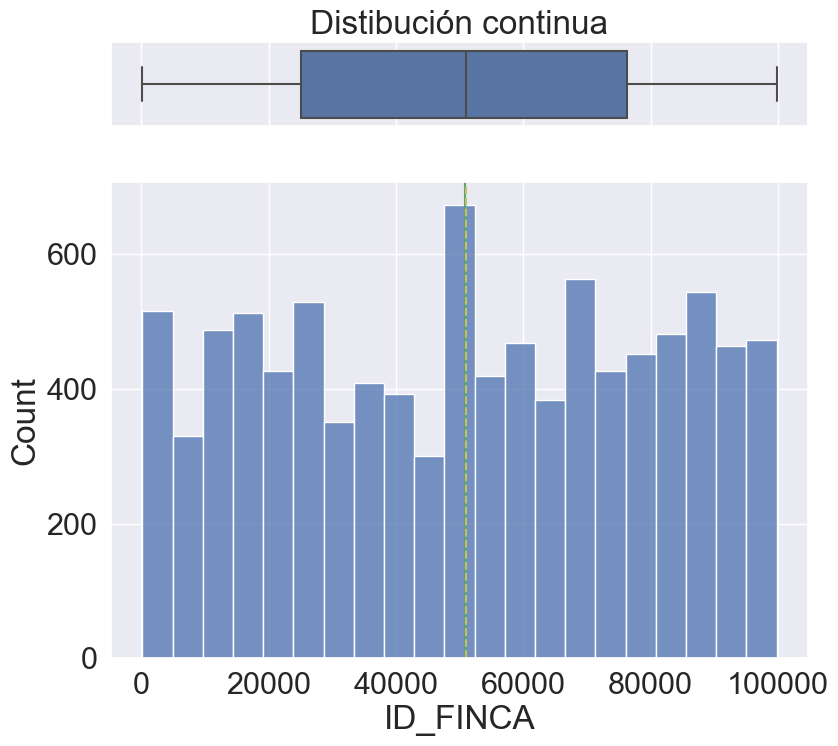

Cont


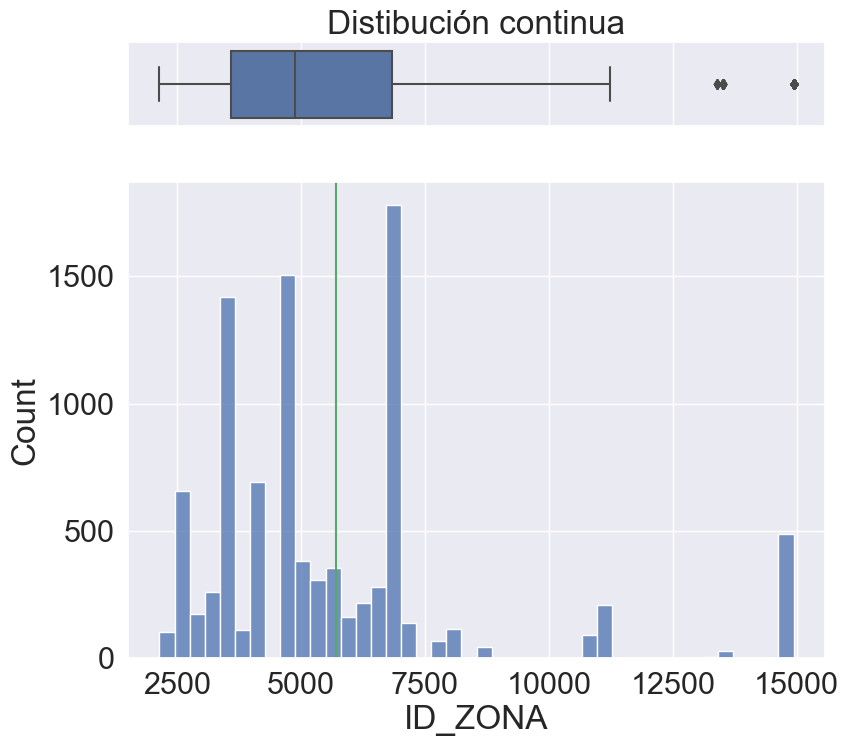

Cont


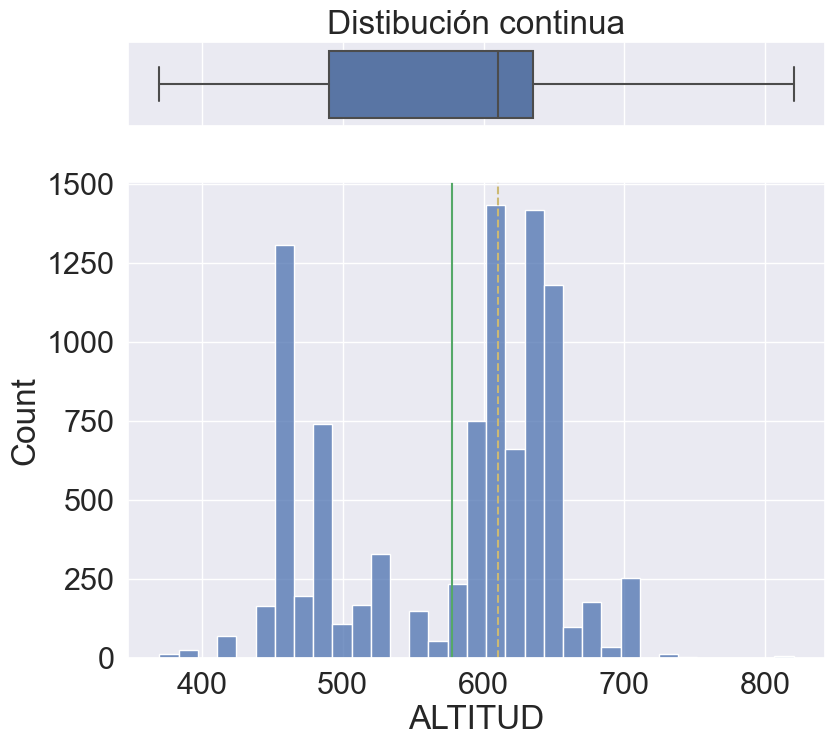

Cont


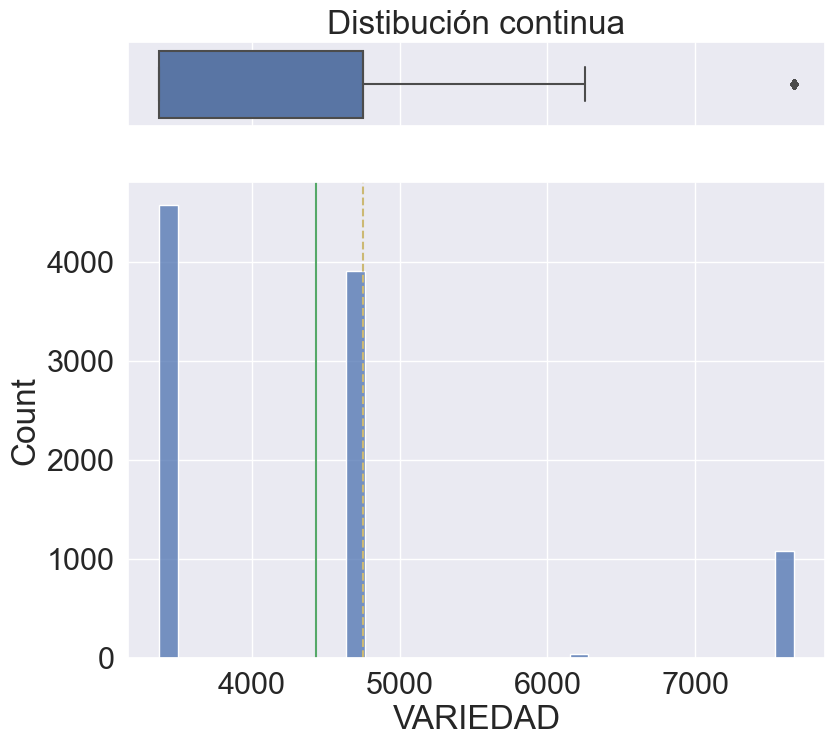

Cont


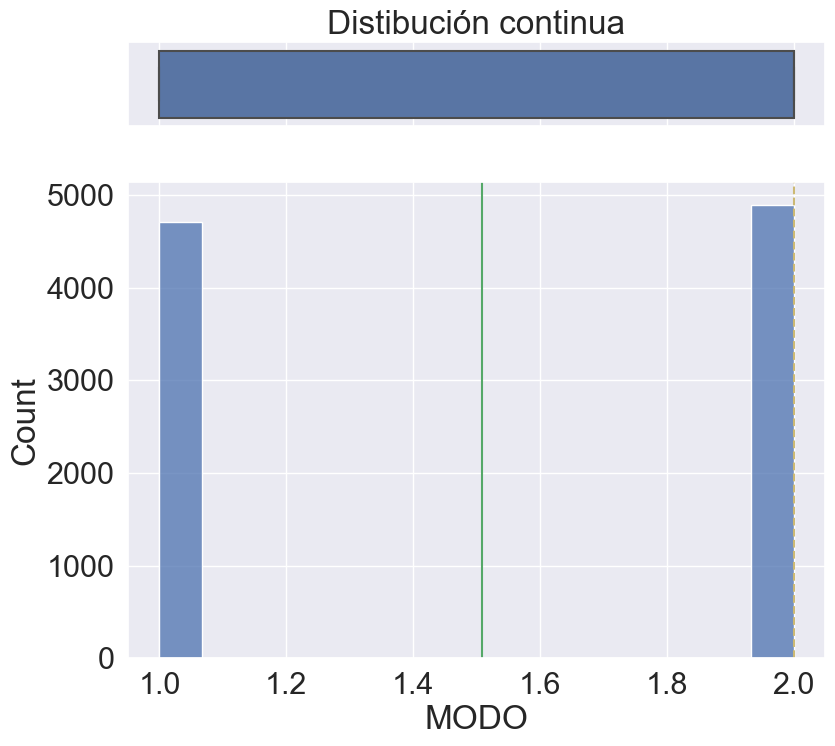

Cont


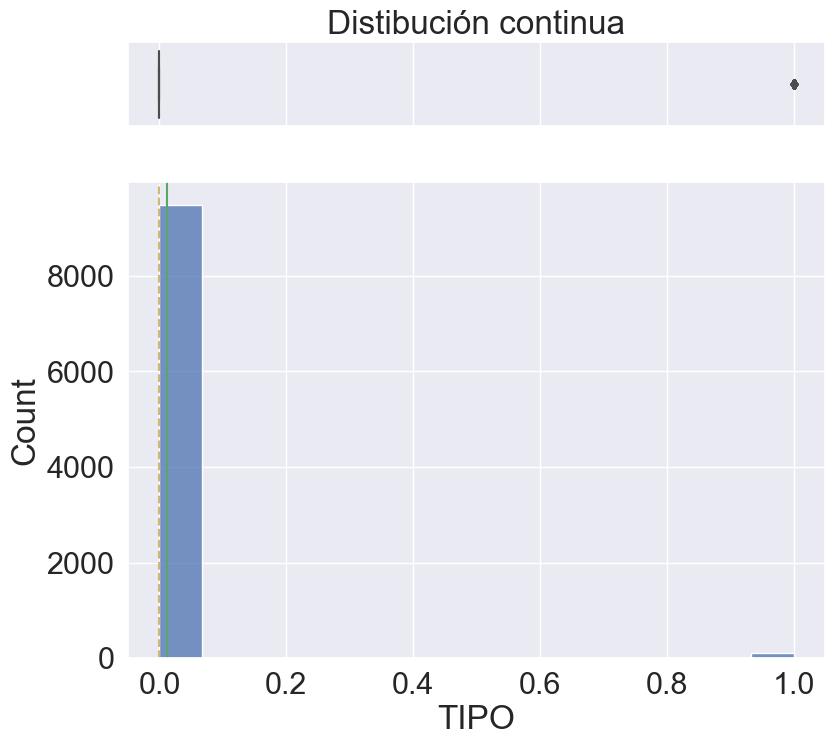

Cont


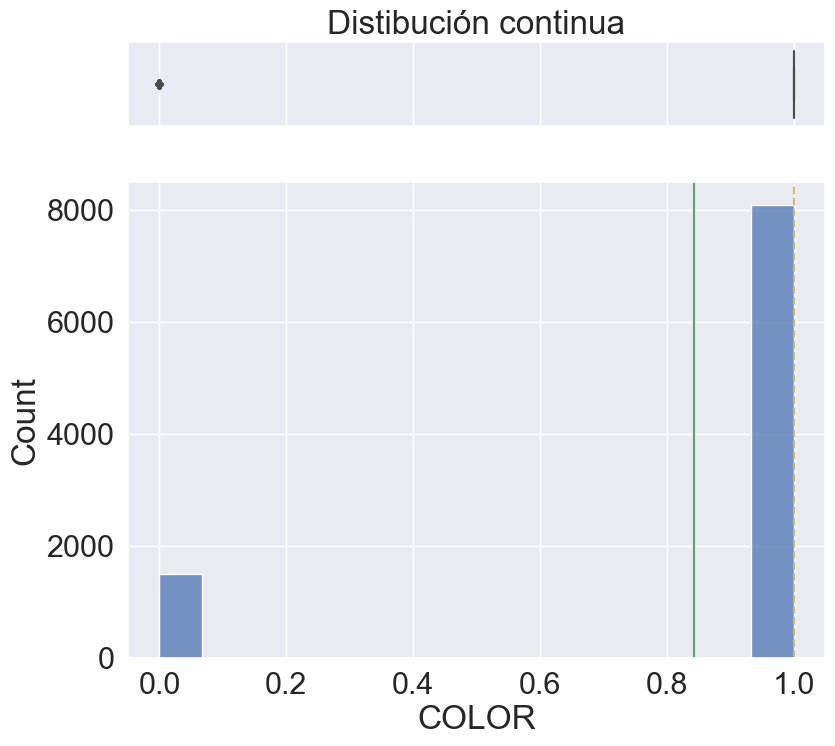

Cont


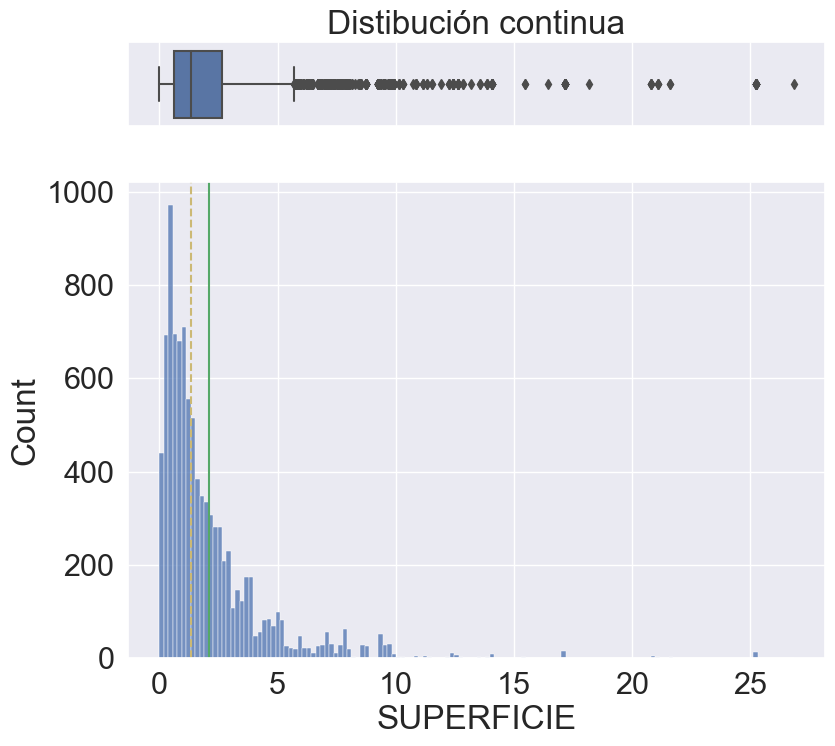

Cont


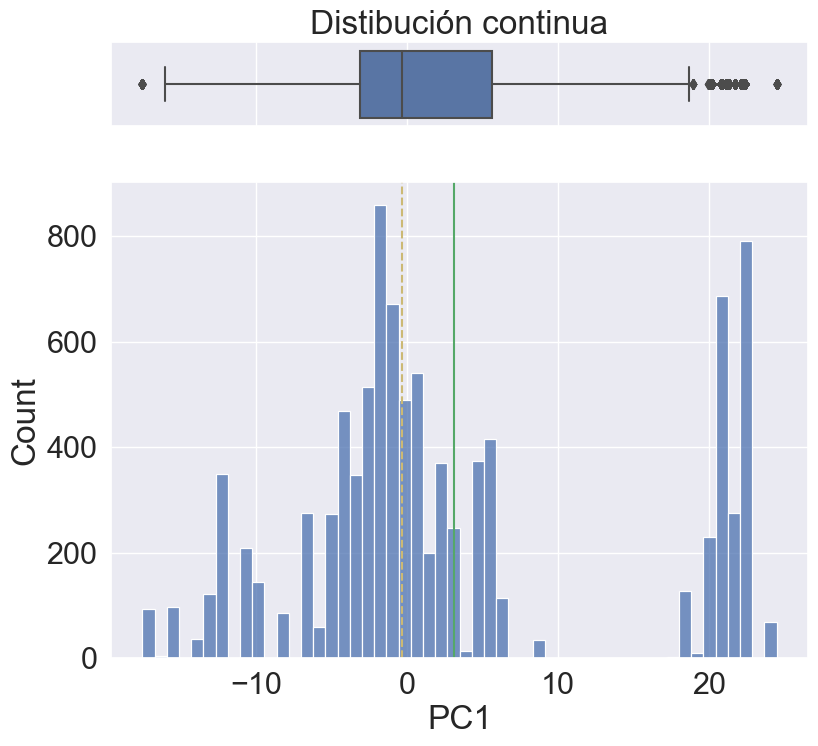

Cont


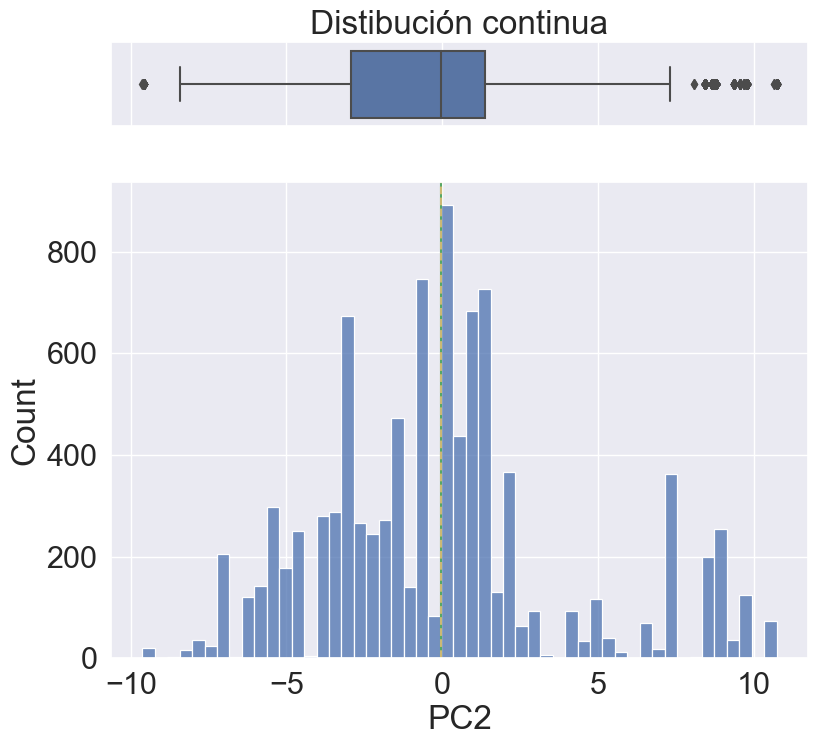

Cont


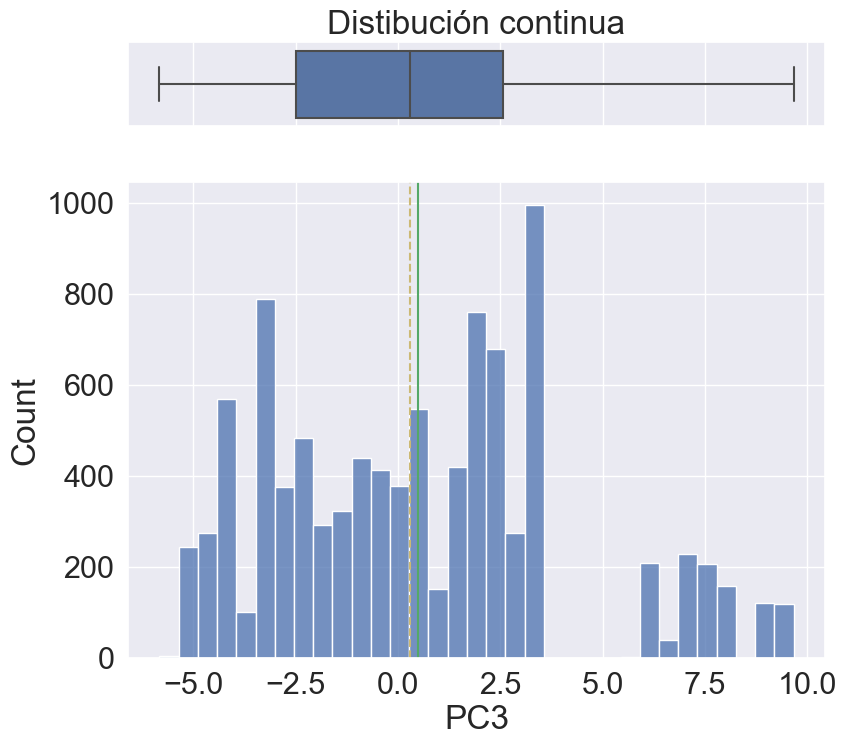

Cont


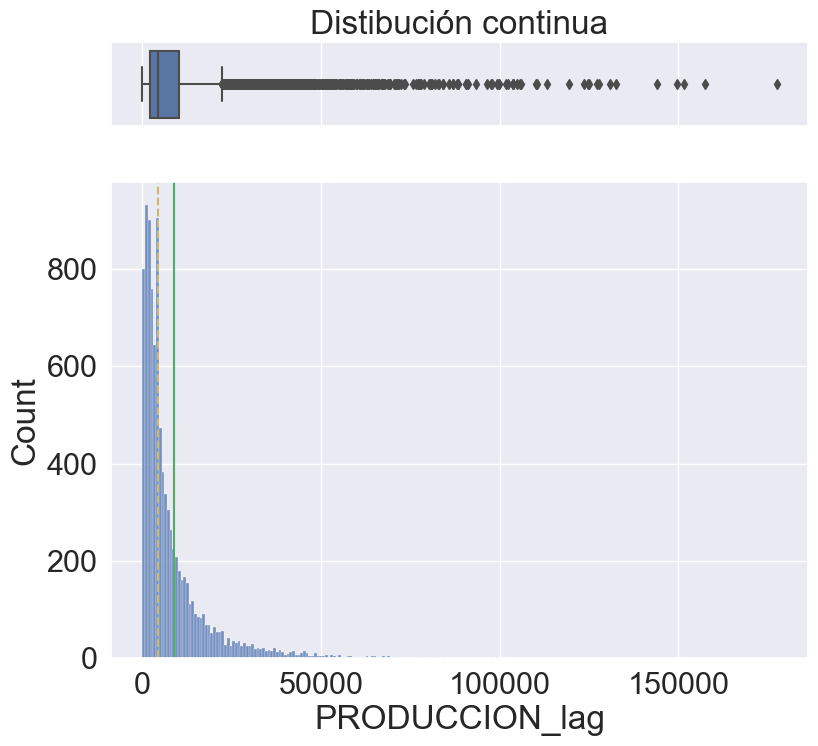

ID_FINCA          None
ID_ZONA           None
ALTITUD           None
VARIEDAD          None
MODO              None
TIPO              None
COLOR             None
SUPERFICIE        None
PC1               None
PC2               None
PC3               None
PRODUCCION_lag    None
dtype: object

In [287]:
dfx.loc[:, ~dfx.columns.isin(['year'])].apply(plot) # la fecha no va

In [288]:
dfx['ID_ZONA'].fillna(dfx['ID_ZONA'].median(), inplace=True)
dfx

,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,year,PC1,PC2,PC3,PRODUCCION_lag
1,200,4876.86,482.50,3375.06,1,0,1,0.37,2014,22.09,-0.51,2.15,2557.73
0,200,4876.86,482.50,3375.06,1,0,1,0.37,2015,22.09,-0.51,2.15,1900.00
3,200,4876.86,482.50,3375.06,1,0,1,0.37,2016,5.65,7.31,0.05,778.10
5,200,4876.86,482.50,3375.06,1,0,1,0.37,2017,2.16,-2.06,-5.10,1636.20
2,200,4876.86,482.50,3375.06,1,0,1,0.37,2018,-0.89,2.31,-4.85,829.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,99693,4878.25,640.00,3375.06,1,0,1,6.35,2020,-2.10,-5.85,1.82,18405.39
9594,99693,4878.25,640.00,3375.06,1,0,1,6.35,2021,-3.09,-3.99,-1.01,26876.30
9598,99693,4878.25,640.00,3375.06,1,0,1,6.34,2022,-13.41,0.56,8.21,35418.70
9599,99793,4878.25,655.00,3375.06,2,0,0,0.02,2022,-17.55,3.95,7.57,4391.69


In [289]:
dfx['VARIEDAD'].unique()

array([3375.06077873, 7664.63687789, 4752.43243243, 6251.10738462])

In [290]:
dfx['VARIEDAD'] = dfx['VARIEDAD'].astype('object')
#for i in dfx.select_dtypes(include=np.number).columns:
#    dfx[i] = np.log(abs(dfx[i] + 0.00001))
#    
#dfx.head()

In [291]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601 entries, 1 to 9600
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_FINCA        9601 non-null   object 
 1   ID_ZONA         9601 non-null   float64
 2   ALTITUD         9601 non-null   float64
 3   VARIEDAD        9601 non-null   object 
 4   MODO            9601 non-null   object 
 5   TIPO            9601 non-null   object 
 6   COLOR           9601 non-null   object 
 7   SUPERFICIE      9601 non-null   float64
 8   year            9601 non-null   int64  
 9   PC1             9601 non-null   float64
 10  PC2             9601 non-null   float64
 11  PC3             9601 non-null   float64
 12  PRODUCCION_lag  9601 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.0+ MB


Cont


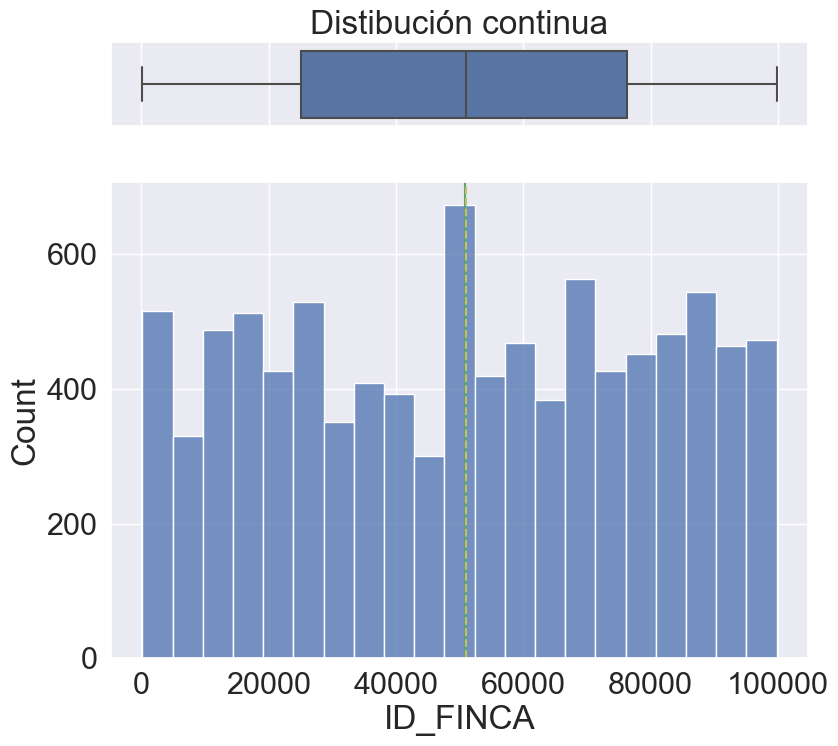

Cont


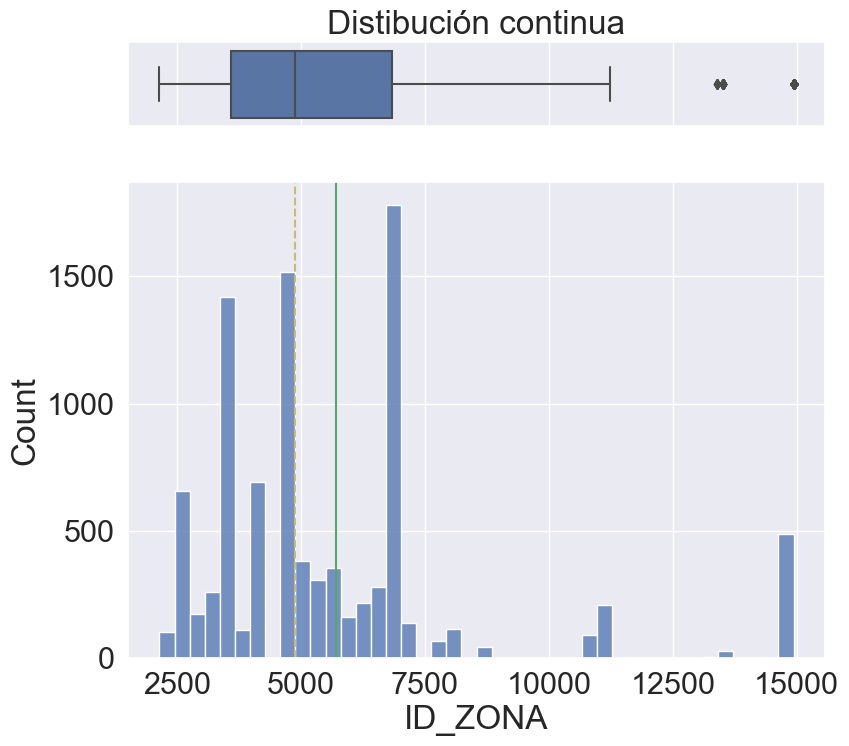

Cont


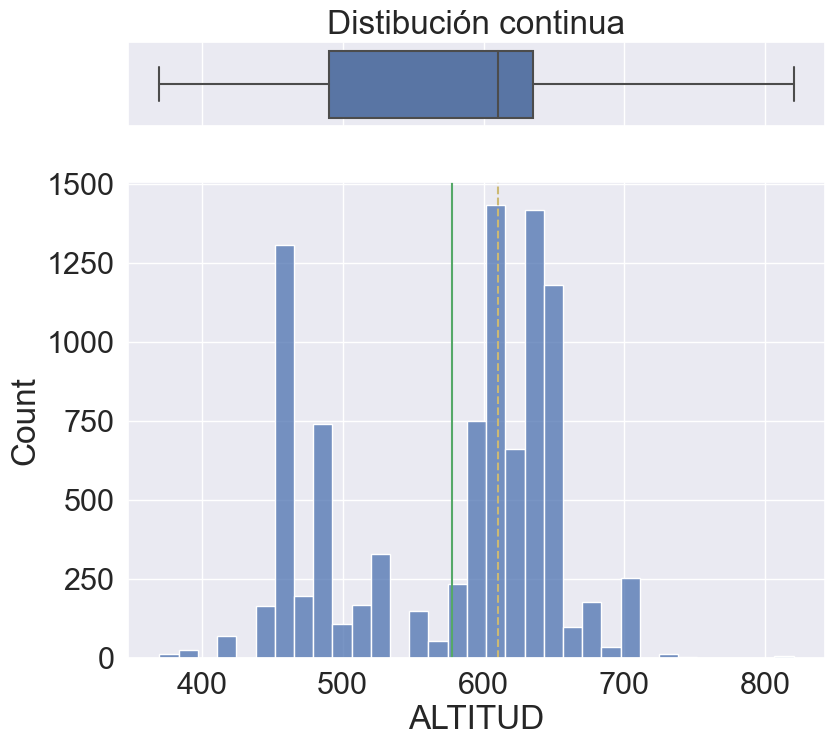

Cont


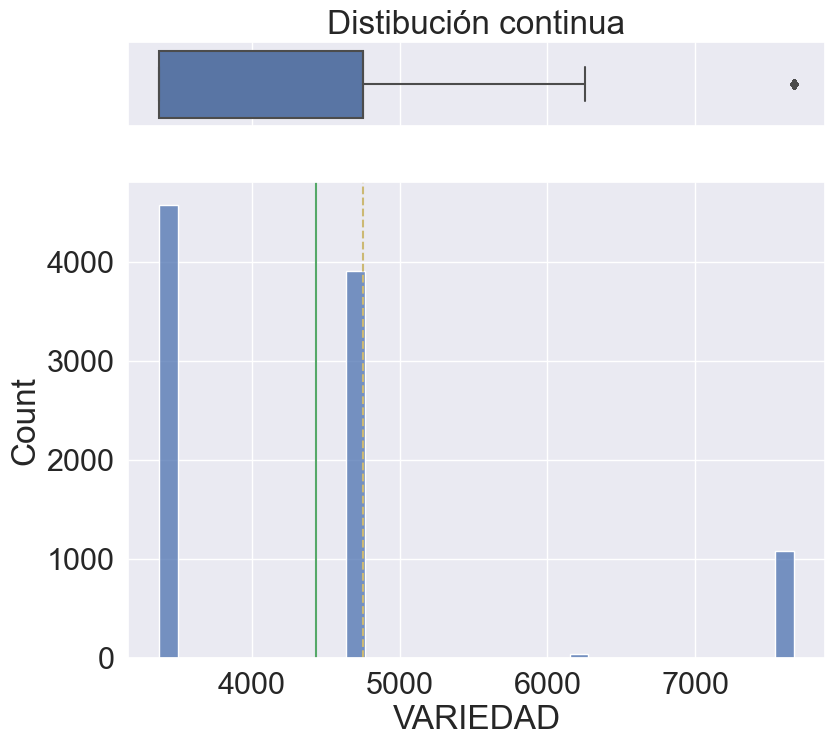

Cont


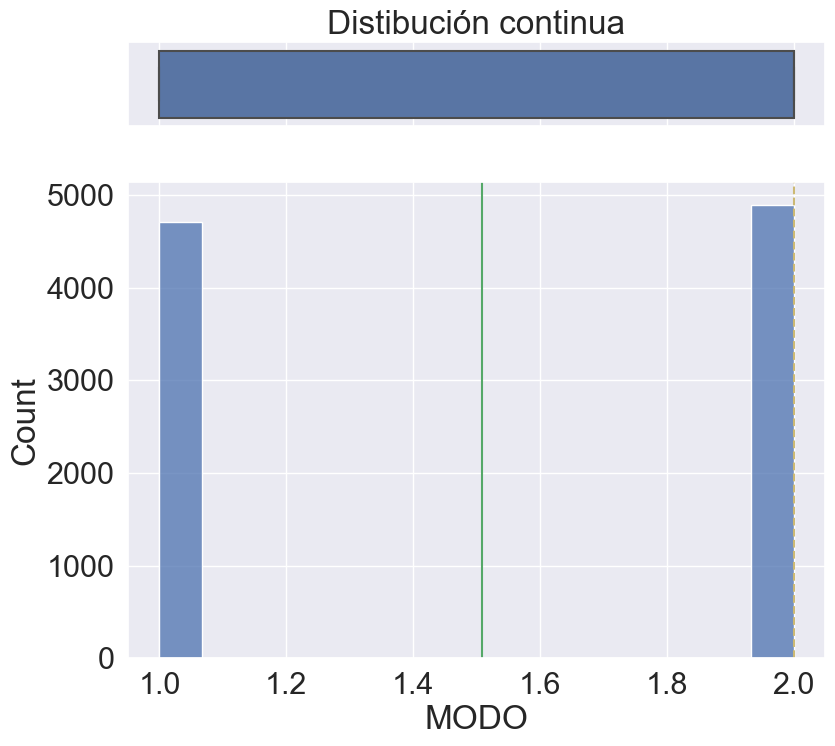

Cont


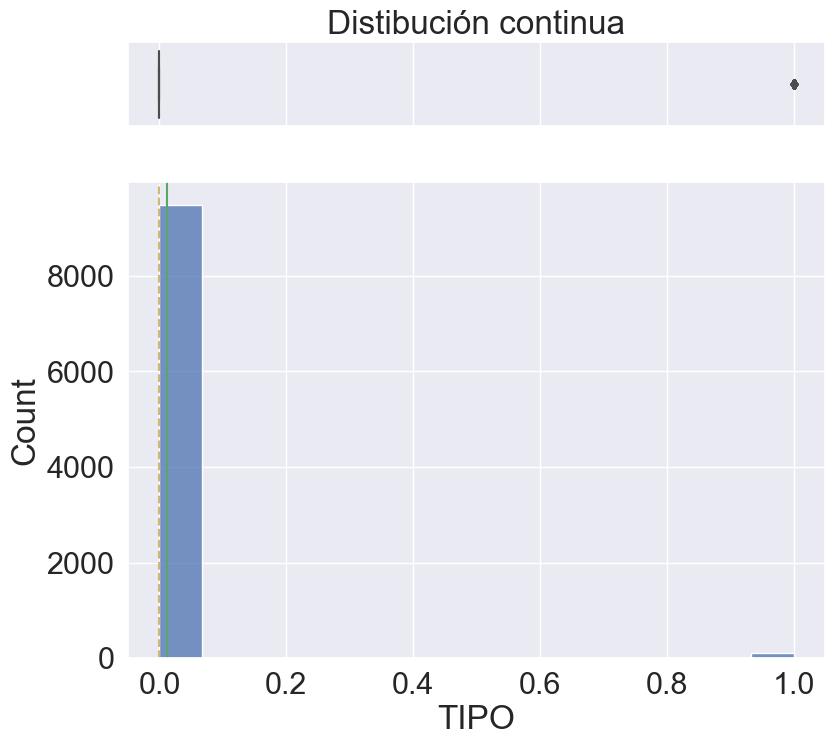

Cont


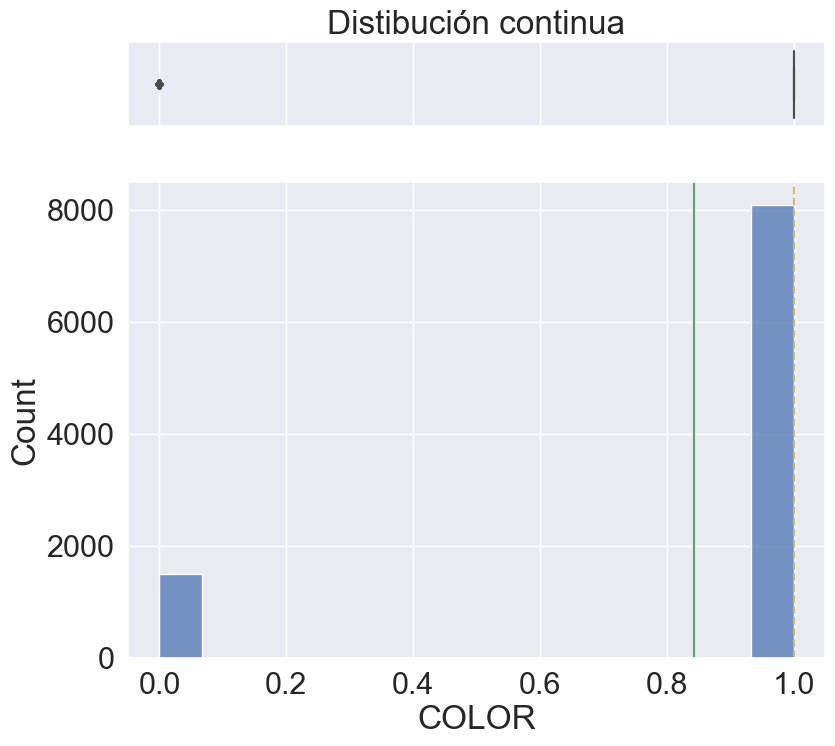

Cont


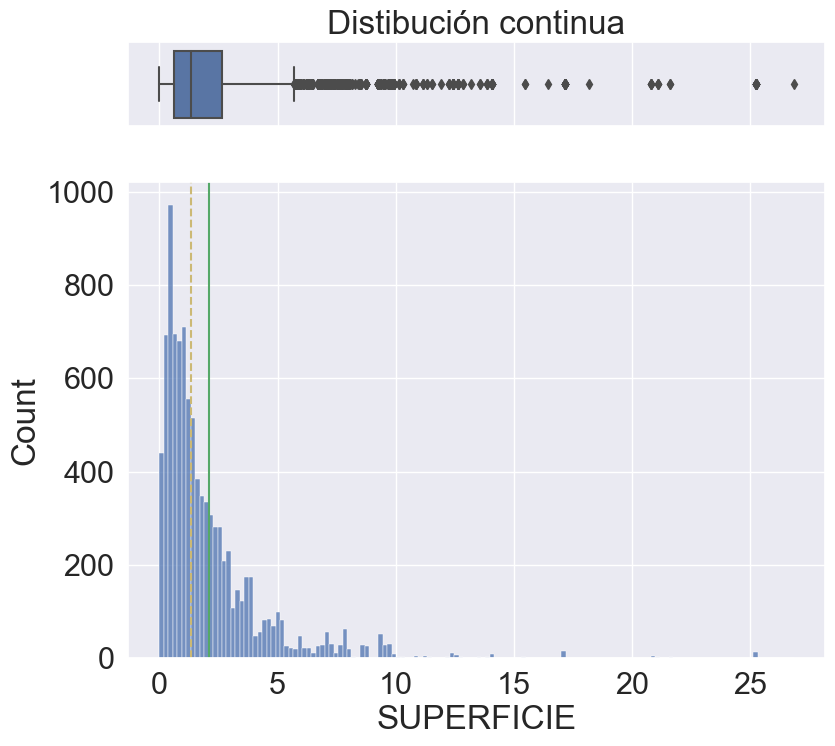

Cont


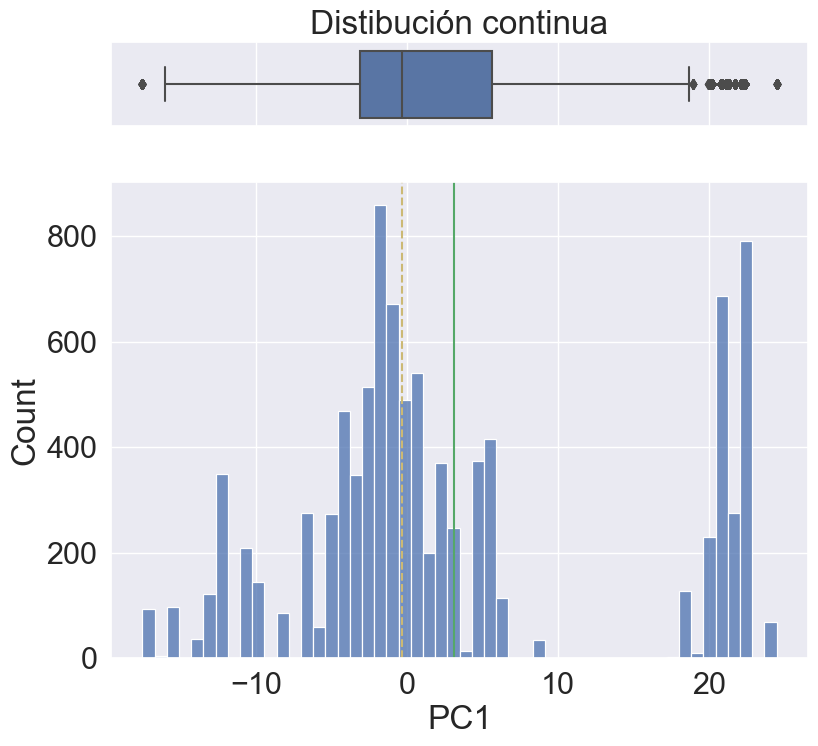

Cont


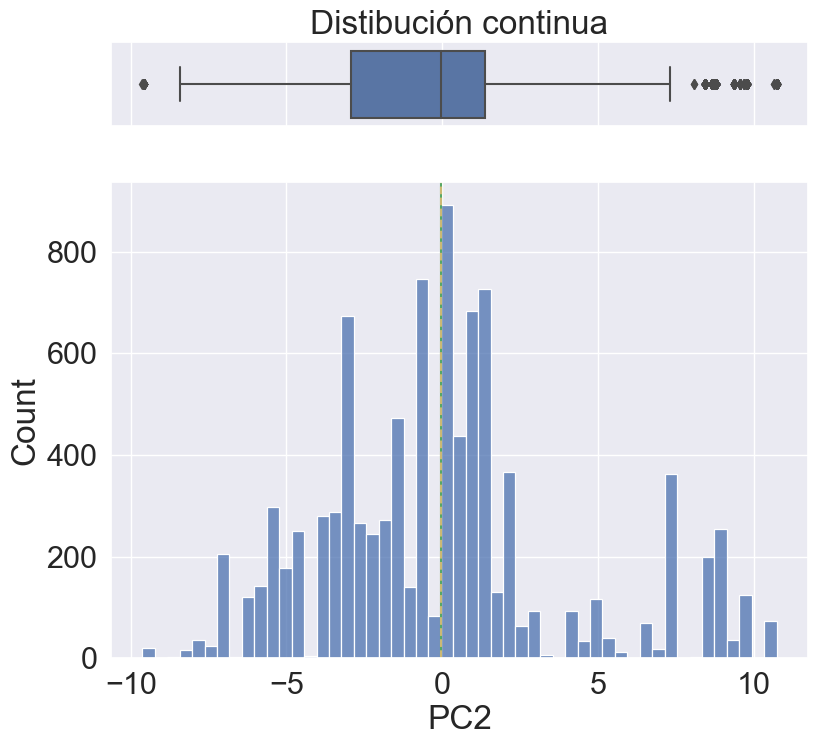

Cont


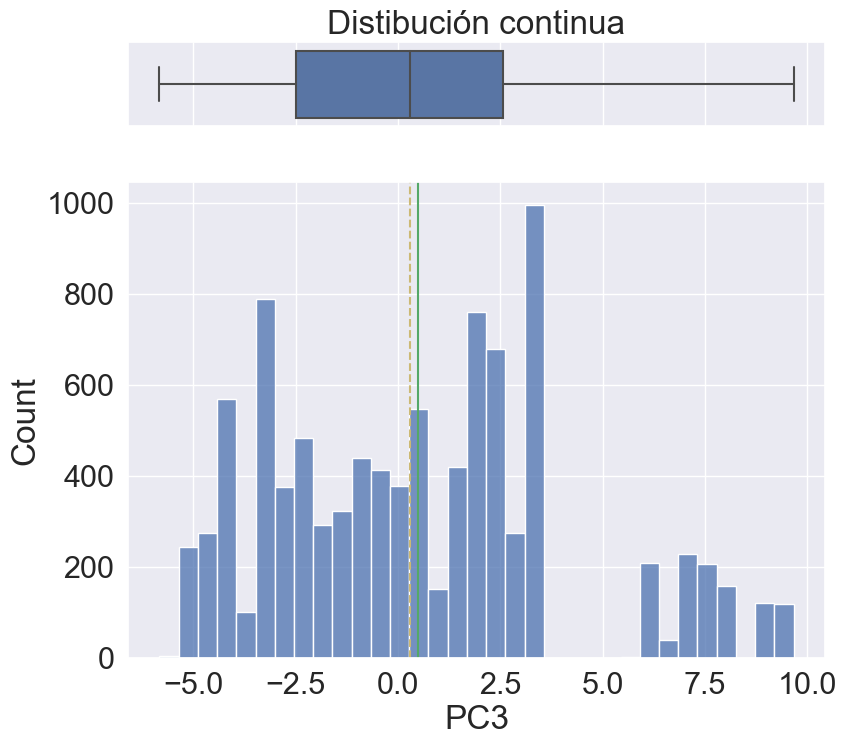

Cont


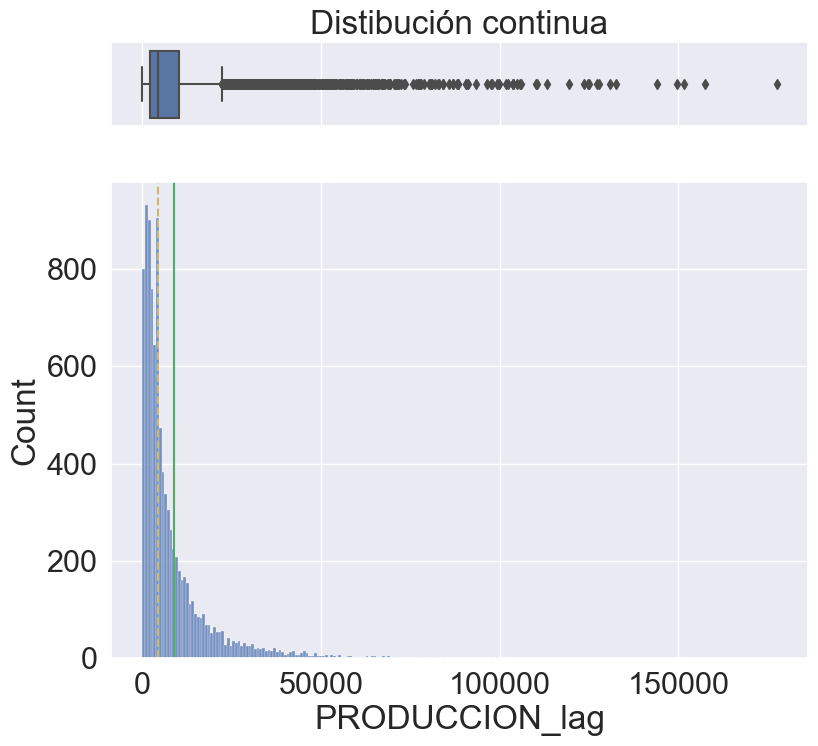

ID_FINCA          None
ID_ZONA           None
ALTITUD           None
VARIEDAD          None
MODO              None
TIPO              None
COLOR             None
SUPERFICIE        None
PC1               None
PC2               None
PC3               None
PRODUCCION_lag    None
dtype: object

In [292]:
dfx.loc[:, ~dfx.columns.isin(['year'])].apply(plot)

In [293]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601 entries, 1 to 9600
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_FINCA        9601 non-null   object 
 1   ID_ZONA         9601 non-null   float64
 2   ALTITUD         9601 non-null   float64
 3   VARIEDAD        9601 non-null   object 
 4   MODO            9601 non-null   object 
 5   TIPO            9601 non-null   object 
 6   COLOR           9601 non-null   object 
 7   SUPERFICIE      9601 non-null   float64
 8   year            9601 non-null   int64  
 9   PC1             9601 non-null   float64
 10  PC2             9601 non-null   float64
 11  PC3             9601 non-null   float64
 12  PRODUCCION_lag  9601 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 1.0+ MB


In [294]:
df_obj = dfx.select_dtypes(include='object').drop('ID_FINCA', axis=1)

# create dummy variables for the resulting DataFrame
dummies = pd.get_dummies(df_obj, drop_first=True)

# concatenate the dummy variables with the original DataFrame
dfx = pd.concat([dfx.drop(df_obj.columns, axis=1), dummies], axis=1)

# print the resulting DataFrame
dfx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601 entries, 1 to 9600
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_FINCA                     9601 non-null   object 
 1   ID_ZONA                      9601 non-null   float64
 2   ALTITUD                      9601 non-null   float64
 3   SUPERFICIE                   9601 non-null   float64
 4   year                         9601 non-null   int64  
 5   PC1                          9601 non-null   float64
 6   PC2                          9601 non-null   float64
 7   PC3                          9601 non-null   float64
 8   PRODUCCION_lag               9601 non-null   float64
 9   VARIEDAD_4752.4324324324325  9601 non-null   uint8  
 10  VARIEDAD_6251.107384615384   9601 non-null   uint8  
 11  VARIEDAD_7664.63687788779    9601 non-null   uint8  
 12  MODO_2                       9601 non-null   uint8  
 13  TIPO_1            

## 3. dataset final y comprobación de bivariantes

In [295]:
dfx = dfx.drop(columns=['ID_FINCA'])

In [301]:
dfy_train = dfy.loc[dfy['year'] < 2021]
dfy_test = dfy.loc[dfy['year'] == 2021]
dfx_train = dfx.loc[dfx['year'] < 2021]
dfx_test = dfx.loc[dfx['year'] == 2021]

In [302]:
dfy_train = dfy_train.drop(columns=['year'])
dfy_test = dfy_test.drop(columns=['year'])
dfx_train = dfx_train.drop(columns=['year'])
dfx_test = dfx_test.drop(columns=['year'])

In [303]:
#dfy = pd.DataFrame(dfy.PRODUCCION)
dfx_test

,ID_ZONA,ALTITUD,SUPERFICIE,PC1,PC2,PC3,PRODUCCION_lag,VARIEDAD_4752.4324324324325,VARIEDAD_6251.107384615384,VARIEDAD_7664.63687788779,MODO_2,TIPO_1,COLOR_1
7,5493.35,605.00,1.08,-1.80,-2.92,-2.49,6354.40,1,0,0,1,0,0
17,2504.93,470.00,0.47,-0.32,-3.01,-3.40,2828.54,0,0,1,1,0,1
20,2504.93,635.00,0.65,-2.17,-4.57,-0.64,947.84,1,0,0,1,0,1
35,4607.86,647.50,2.39,-3.09,-3.99,-1.01,3130.00,0,0,0,0,0,0
36,4607.86,647.50,7.51,-3.09,-3.99,-1.01,10180.00,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9556,6844.05,590.00,1.61,-1.80,-2.92,-2.49,6140.00,0,0,1,1,0,1
9570,6844.05,610.00,0.83,-2.17,-4.57,-0.64,3300.00,1,0,0,1,0,1
9578,6844.05,490.00,1.62,-0.32,-3.01,-3.40,6710.00,0,0,0,1,0,1
9583,6844.05,460.00,0.65,-0.32,-3.01,-3.40,2300.00,0,0,1,1,0,1


Text(0.5, 1.0, 'Relación bivariante con PRODUCCIÓN')

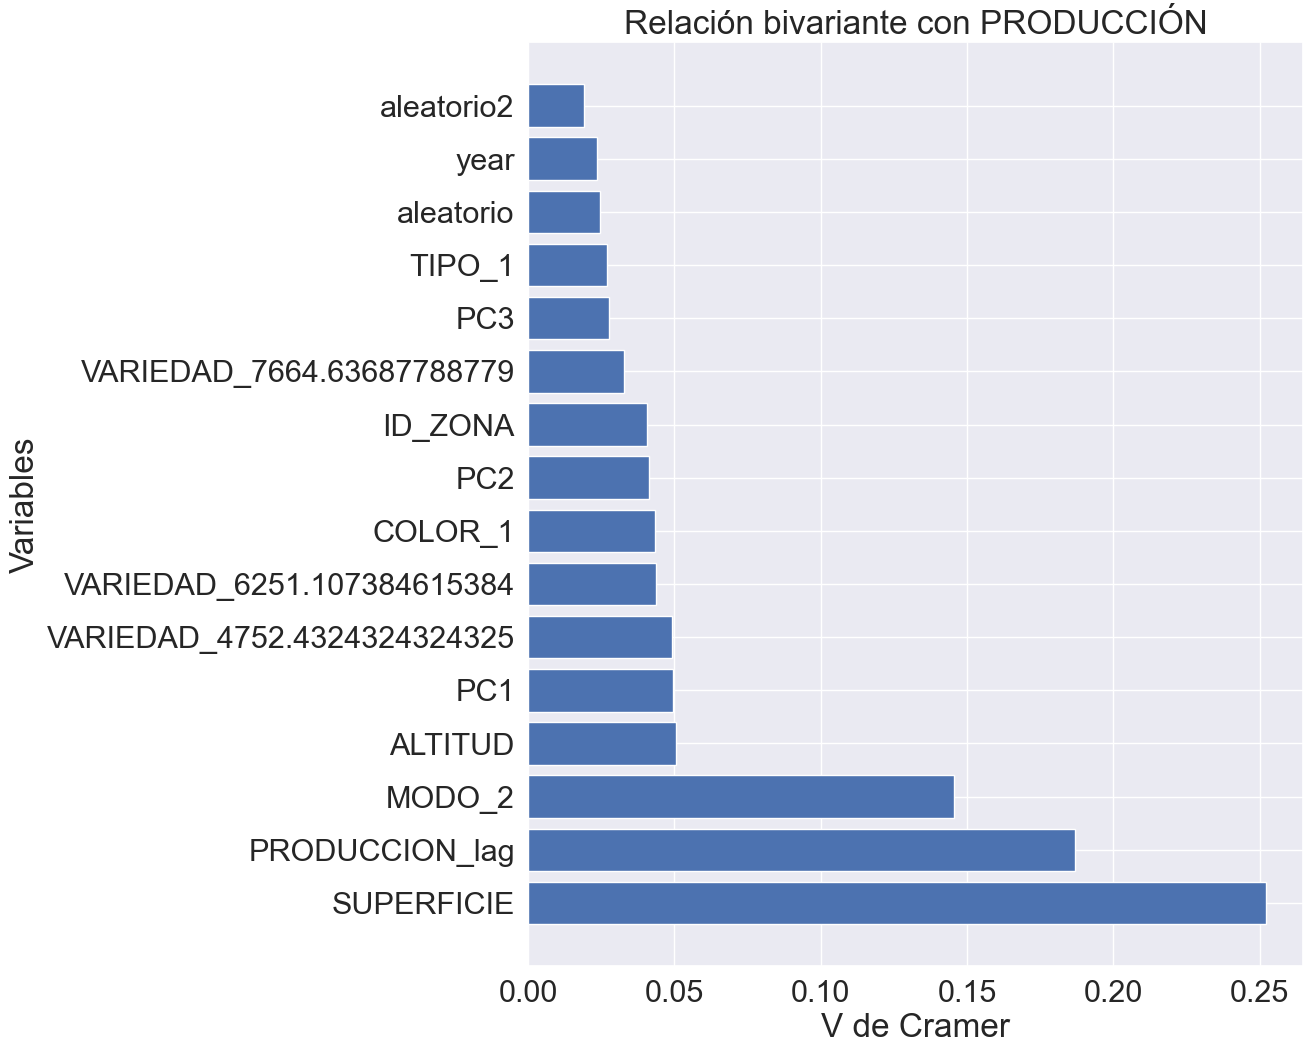

In [304]:
import plotly.express as px
import scipy.stats as stats
from sklearn.preprocessing import scale

dfx['aleatorio'] = np.random.uniform(0,1,size=dfx.shape[0])
dfx['aleatorio2'] = np.random.uniform(0,1,size=dfx.shape[0])

tablaCramer = pd.DataFrame(dfx.apply(lambda x: cramers_v(x,dfy.PRODUCCION)),columns=['VCramer'])

# Obtener el gráfico de importancia de las variables frente a la objetivo continua según vcramer

#px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a PRODUCCION').update_yaxes(categoryorder="total ascending")
tablaCramer = tablaCramer.sort_values(by='VCramer', ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(10, 12))
plt.barh(tablaCramer.index, tablaCramer['VCramer'])

# Add labels and title
plt.xlabel('V de Cramer')
plt.ylabel('Variables')
plt.title('Relación bivariante con PRODUCCIÓN')

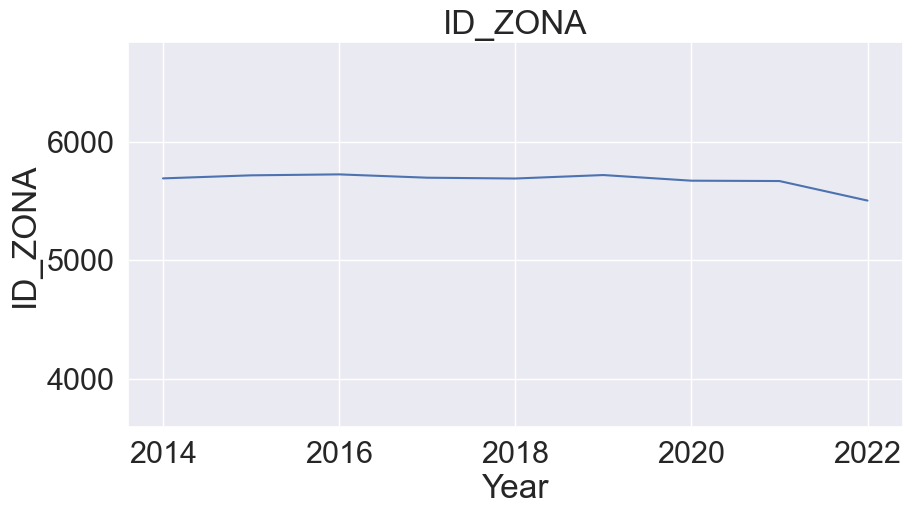

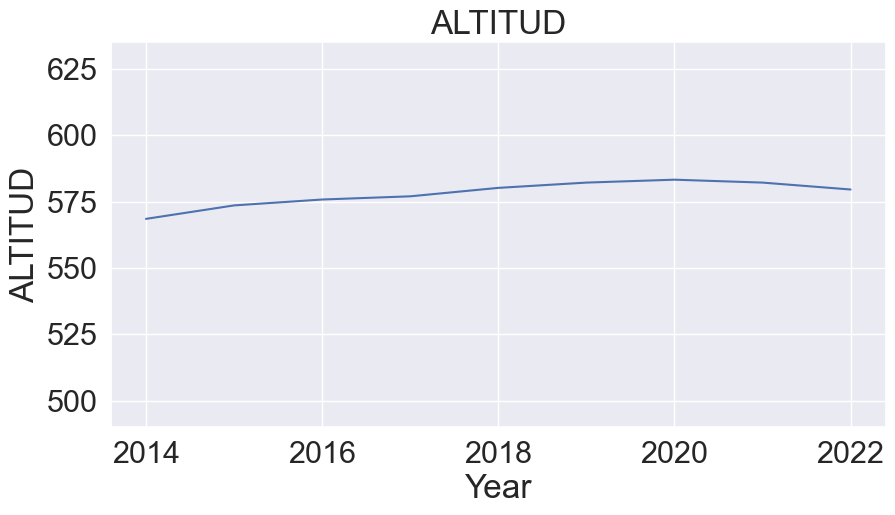

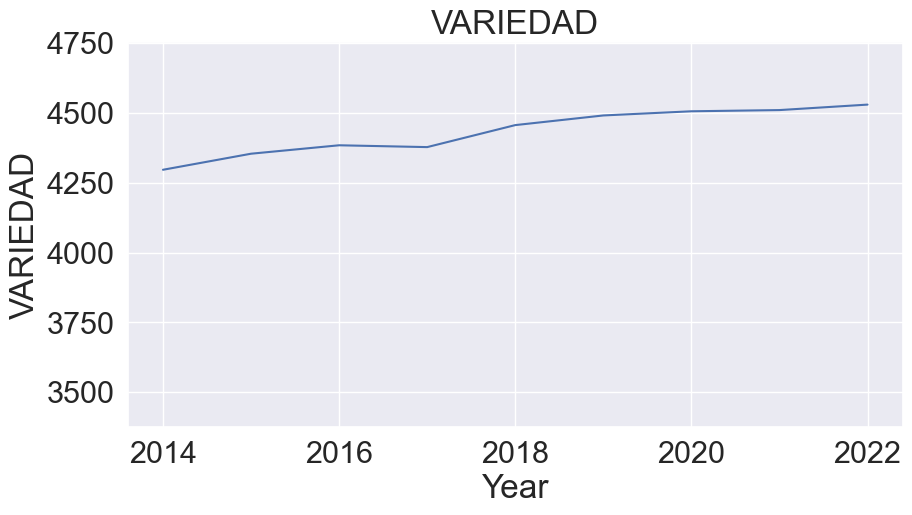

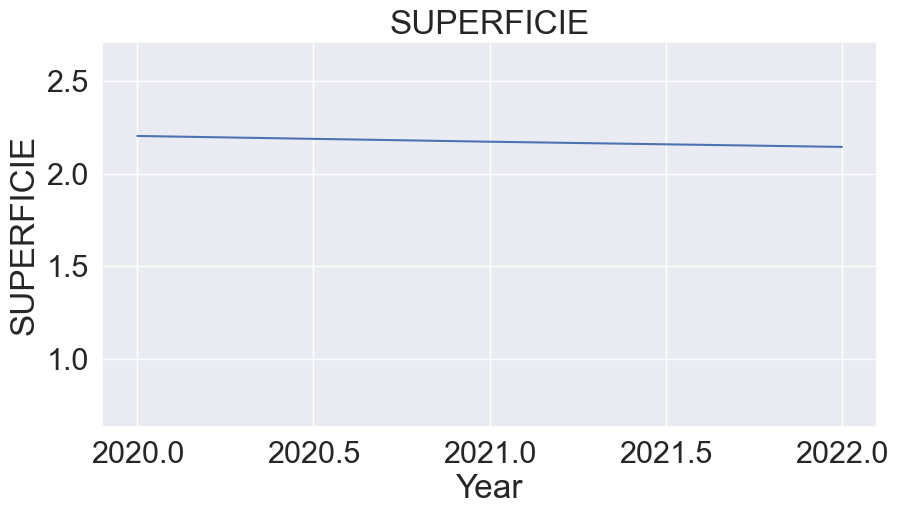

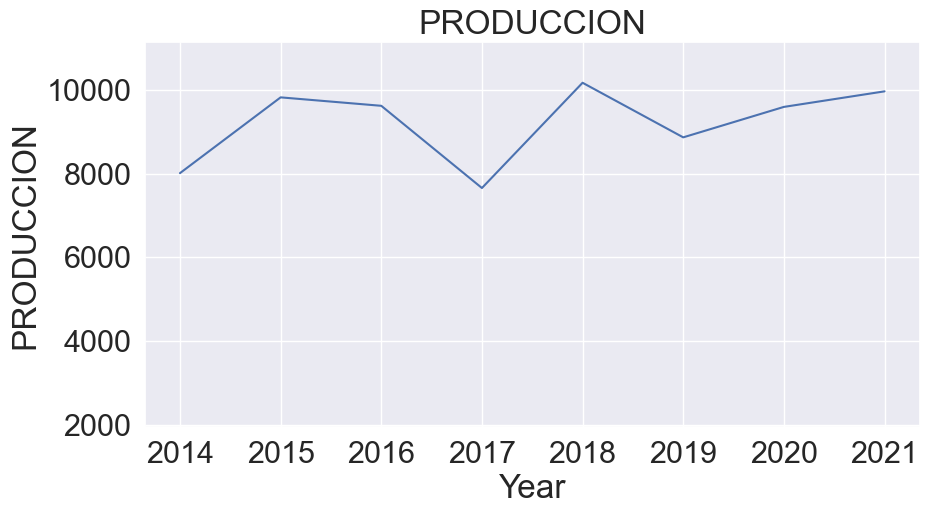

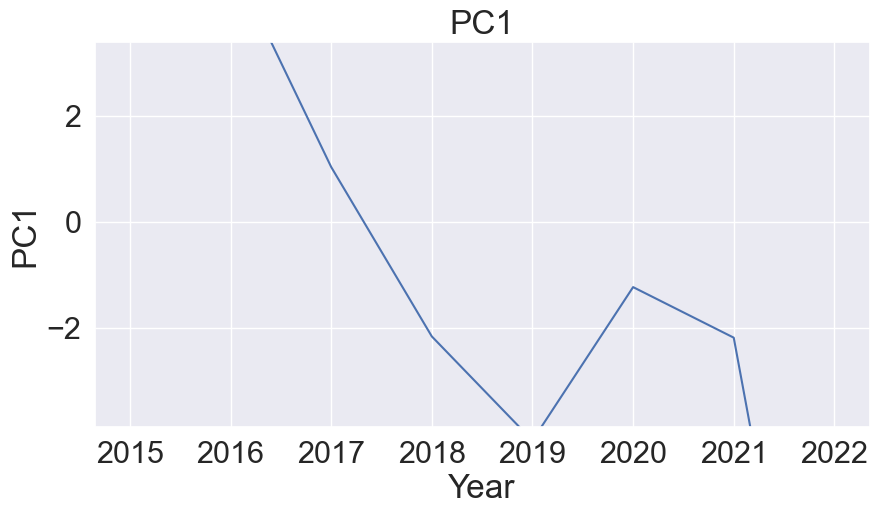

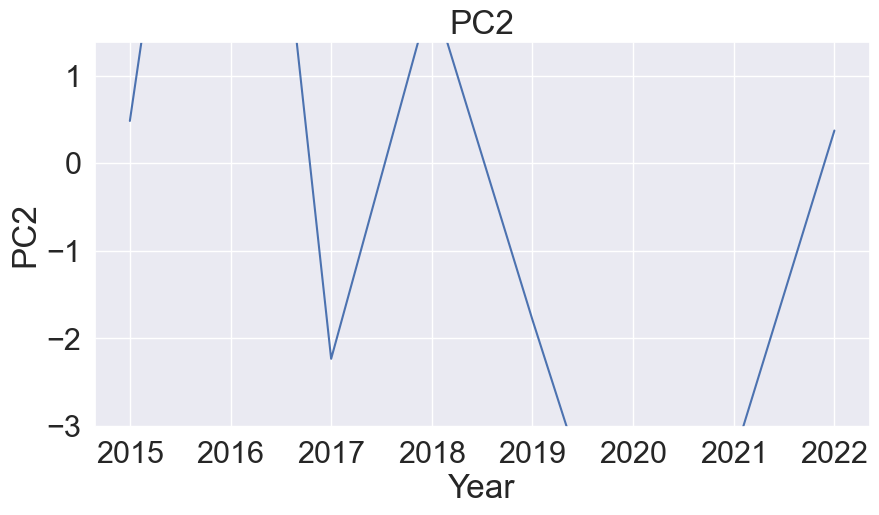

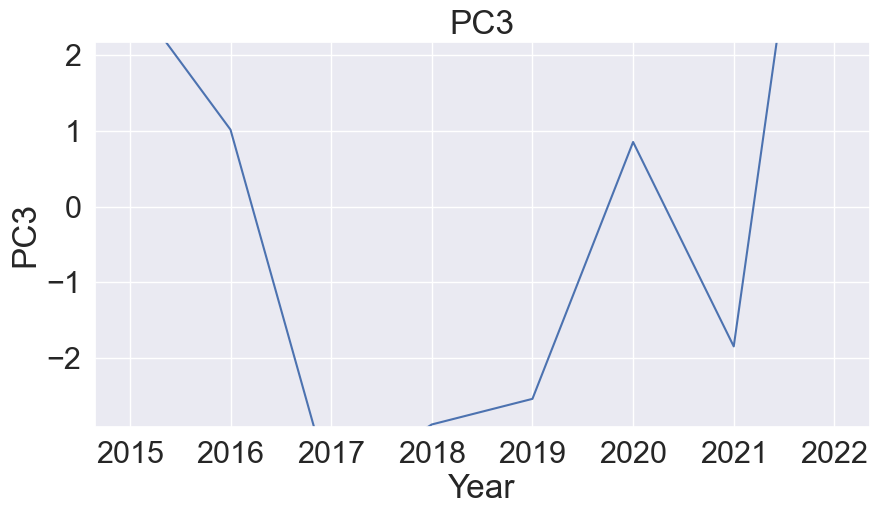

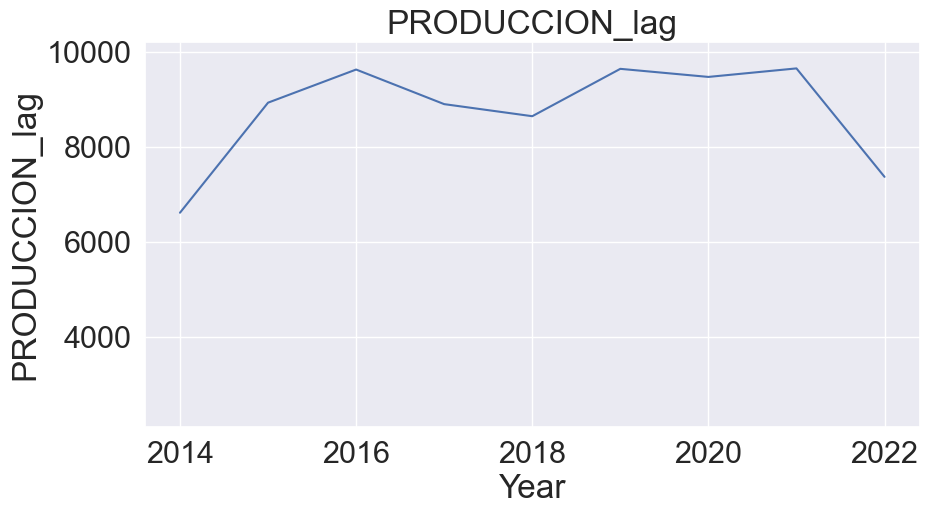

In [305]:
import numpy as np

# Select only numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['year'])


# Group by mean and plot the evolution of each numerical column
for col in num_cols:
    means = df.groupby('year')[col].mean()
    q25, q75 = np.percentile(df[col].dropna(), [25, 75])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(means.index, means.values)
    ax.set_ylim(q25, q75)
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    ax.set_title(col)
    plt.show()

In [306]:
dfx = dfx.drop(columns=['aleatorio', 'aleatorio2'])

In [311]:
numerical_vars

,ID_ZONA,ALTITUD,SUPERFICIE,year,PC1,PC2,PC3,PRODUCCION_lag,VARIEDAD_4752.4324324324325,VARIEDAD_6251.107384615384,VARIEDAD_7664.63687788779,MODO_2,TIPO_1,COLOR_1
1,4876.86,482.50,0.37,2014,22.09,-0.51,2.15,2557.73,0,0,0,0,0,1
0,4876.86,482.50,0.37,2015,22.09,-0.51,2.15,1900.00,0,0,0,0,0,1
3,4876.86,482.50,0.37,2016,5.65,7.31,0.05,778.10,0,0,0,0,0,1
5,4876.86,482.50,0.37,2017,2.16,-2.06,-5.10,1636.20,0,0,0,0,0,1
2,4876.86,482.50,0.37,2018,-0.89,2.31,-4.85,829.01,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,4878.25,640.00,6.35,2020,-2.10,-5.85,1.82,18405.39,0,0,0,0,0,1
9594,4878.25,640.00,6.35,2021,-3.09,-3.99,-1.01,26876.30,0,0,0,0,0,1
9598,4878.25,640.00,6.34,2022,-13.41,0.56,8.21,35418.70,0,0,0,0,0,1
9599,4878.25,655.00,0.02,2022,-17.55,3.95,7.57,4391.69,0,0,0,1,0,0


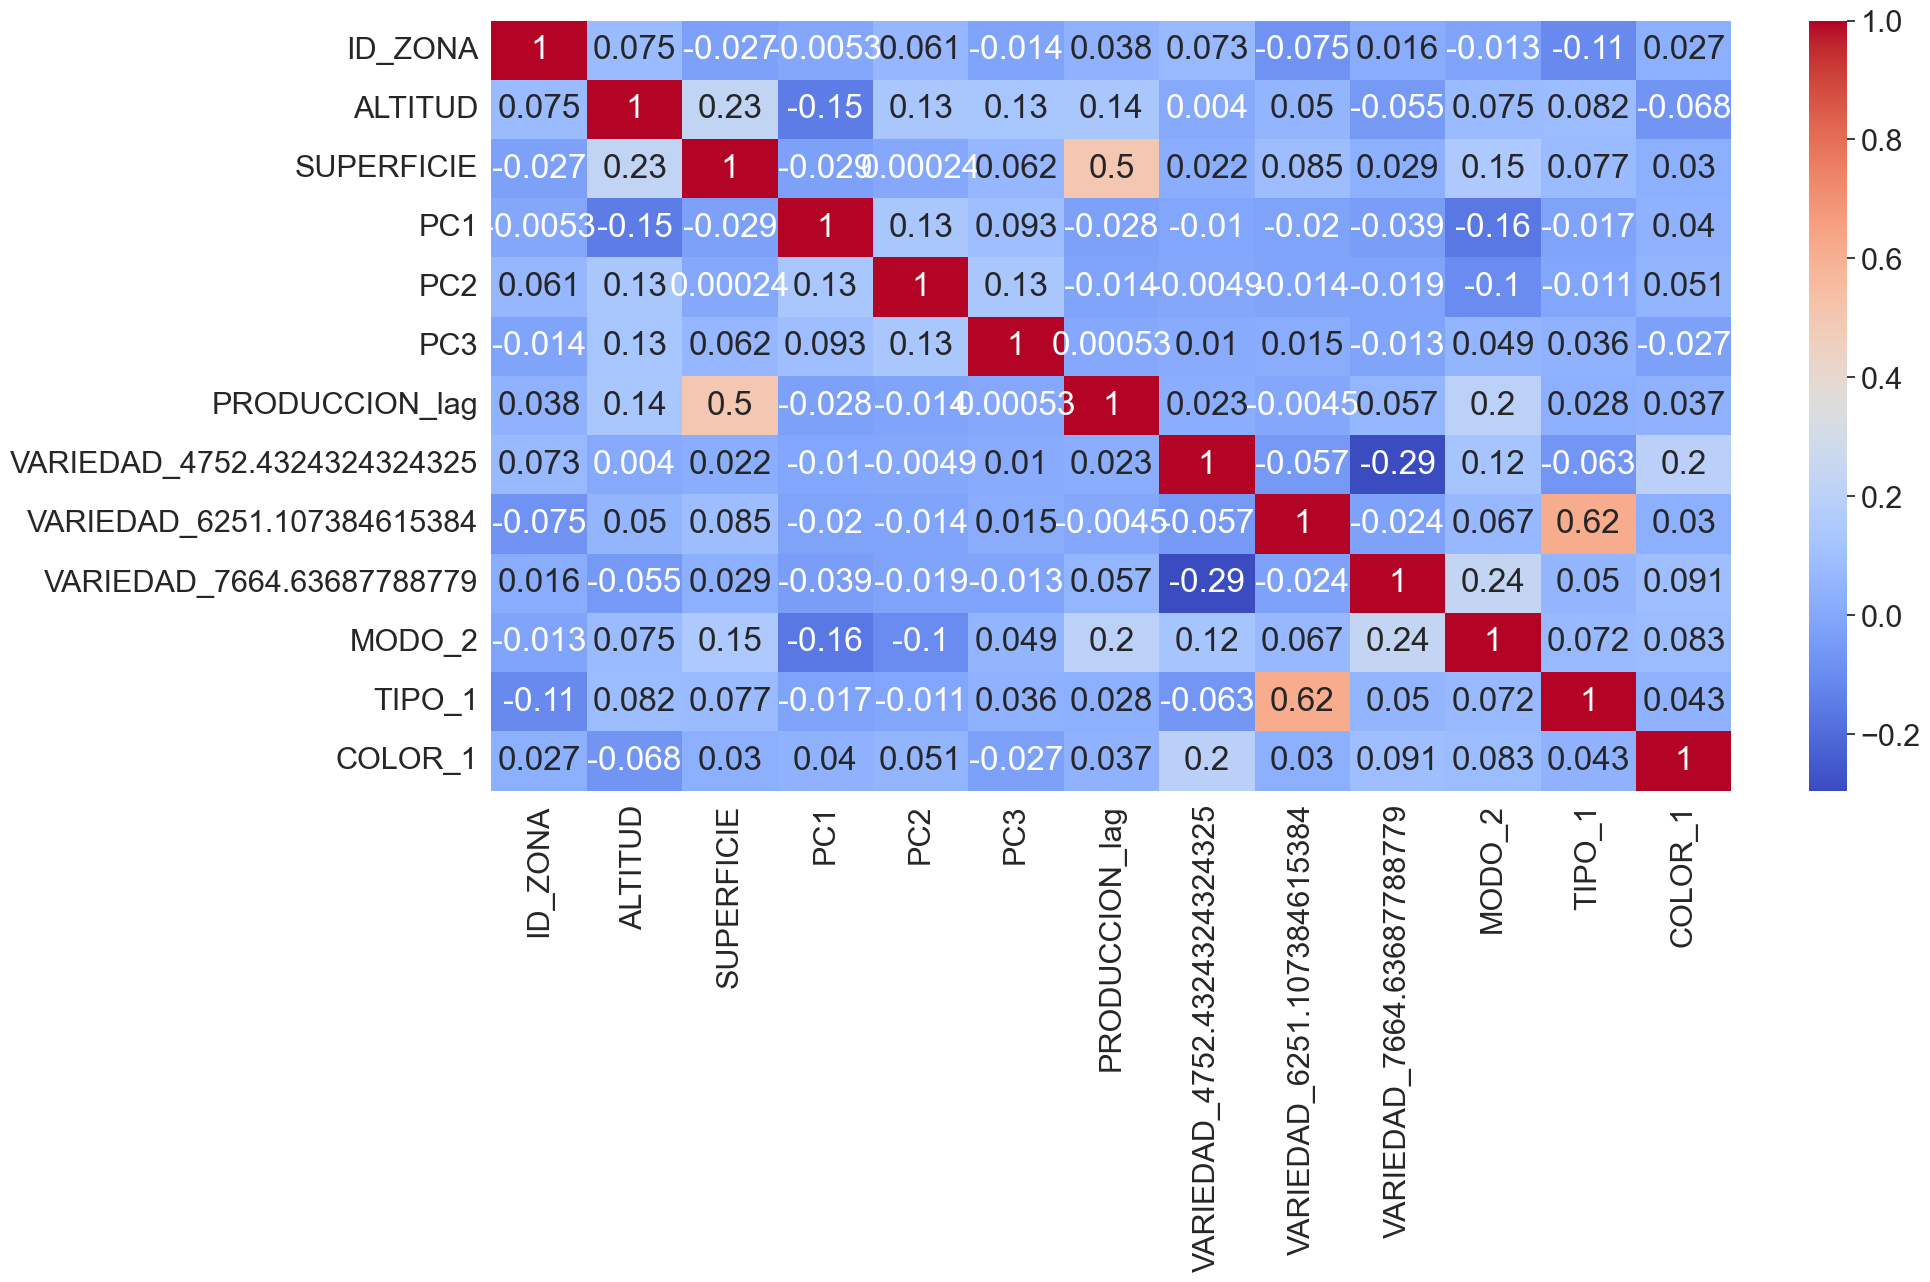

In [314]:
#numerical_vars = dfx.select_dtypes(include=[np.number])
numerical_vars = dfx.drop(columns='year')
corr_matrix = numerical_vars.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [316]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["variable"] = numerical_vars.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(numerical_vars.values, i)
                          for i in range(len(numerical_vars.columns))]

print("Parece haber multicolinealidad en COLOR, ALTITUD y ZONA... Pero asumimos que un modelo de árbol podra lidiar con ella\n")
  
print(vif_data)

Parece haber multicolinealidad en COLOR, ALTITUD y ZONA... Pero asumimos que un modelo de árbol podra lidiar con ella

                       variable   VIF
0                       ID_ZONA  5.07
1                       ALTITUD 10.47
2                    SUPERFICIE  2.45
3                           PC1  1.13
4                           PC2  1.05
5                           PC3  1.07
6                PRODUCCION_lag  2.06
7   VARIEDAD_4752.4324324324325  2.06
8    VARIEDAD_6251.107384615384  1.64
9     VARIEDAD_7664.63687788779  1.40
10                       MODO_2  2.46
11                       TIPO_1  1.66
12                      COLOR_1  6.28


## 4. Modelización y predicción
### 4.1. Primera selección de modelos

In [317]:
from lazypredict.Supervised import LazyRegressor
import lazypredict
lazypredict.Supervised.REGRESSORS

[('ElasticNet', sklearn.linear_model._coordinate_descent.ElasticNet),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('Lasso', sklearn.linear_model._coordinate_descent.Lasso),
 ('LinearRegression', sklearn.linear_model._base.LinearRegression),
 ('RandomForestRegressor', sklearn.ensemble._forest.RandomForestRegressor),
 ('Ridge', sklearn.linear_model._ridge.Ridge),
 ('XGBRegressor', xgboost.sklearn.XGBRegressor),
 ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor)]

In [318]:
# esto pq algunos tardan demasiado en iterar
lista_modelos = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor']
                 #, 'LGBMRegressor', 'XGBRegressor', 
                 #'SVR', 'ElasticNet', 'AdaBoostRegressor']

matching_elements = [elem for elem in lazypredict.Supervised.REGRESSORS if elem[0] in lista_modelos]

print(matching_elements)

[('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('GradientBoostingRegressor', <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>), ('Lasso', <class 'sklearn.linear_model._coordinate_descent.Lasso'>), ('LinearRegression', <class 'sklearn.linear_model._base.LinearRegression'>), ('RandomForestRegressor', <class 'sklearn.ensemble._forest.RandomForestRegressor'>), ('Ridge', <class 'sklearn.linear_model._ridge.Ridge'>), ('XGBRegressor', <class 'xgboost.sklearn.XGBRegressor'>), ('LGBMRegressor', <class 'lightgbm.sklearn.LGBMRegressor'>)]


In [319]:
lazypredict.Supervised.REGRESSORS = matching_elements
for i in range(2015, 2022):
    dfy_train = dfy.loc[dfy['year'] < i]
    dfy_test = dfy.loc[dfx['year'] == i]
    dfx_train = dfx.loc[dfx['year'] < i]
    dfx_test = dfx.loc[dfx['year'] == i]
    dfy_train = dfy_train.drop(columns=['year'])
    dfy_test = dfy_test.drop(columns=['year'])
    dfx_train = dfx_train.drop(columns=['year'])
    dfx_test = dfx_test.drop(columns=['year'])
    X_train = dfx_train
    X_test = dfx_test
    y_train = dfy_train.PRODUCCION
    y_test = dfy_test.PRODUCCION
    reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    print(models)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.99it/s]


                           Adjusted R-Squared  R-Squared     RMSE  Time Taken
Model                                                                        
RandomForestRegressor                    0.39       0.40 11251.38        0.60
Ridge                                    0.37       0.38 11423.05        0.01
Lasso                                    0.37       0.38 11423.76        0.01
LinearRegression                         0.37       0.38 11423.79        0.01
ElasticNet                               0.37       0.38 11453.02        0.01
LGBMRegressor                            0.36       0.36 11587.29        0.09
XGBRegressor                             0.33       0.34 11778.59        0.10
GradientBoostingRegressor                0.26       0.27 12426.84        0.17


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.94it/s]


                           Adjusted R-Squared  R-Squared     RMSE  Time Taken
Model                                                                        
RandomForestRegressor                    0.50       0.51  9739.88        1.05
GradientBoostingRegressor                0.47       0.47 10068.55        0.29
XGBRegressor                             0.43       0.43 10419.36        0.14
ElasticNet                               0.36       0.37 11027.74        0.02
Lasso                                    0.35       0.35 11124.63        0.01
Ridge                                    0.35       0.35 11127.13        0.01
LinearRegression                         0.35       0.35 11127.60        0.01
LGBMRegressor                            0.29       0.30 11600.94        0.09


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.47it/s]


                           Adjusted R-Squared  R-Squared     RMSE  Time Taken
Model                                                                        
ElasticNet                               0.40       0.41  8944.85        0.02
Lasso                                    0.39       0.40  8998.35        0.01
Ridge                                    0.39       0.40  9000.98        0.01
LinearRegression                         0.39       0.40  9001.31        0.01
LGBMRegressor                            0.38       0.39  9050.28        0.11
GradientBoostingRegressor                0.23       0.24 10122.23        0.39
XGBRegressor                             0.15       0.16 10653.10        0.18
RandomForestRegressor                   -0.00       0.01 11536.19        1.58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.72it/s]


                           Adjusted R-Squared  R-Squared     RMSE  Time Taken
Model                                                                        
XGBRegressor                             0.46       0.47 10816.95        0.22
RandomForestRegressor                    0.42       0.43 11199.56        2.07
LGBMRegressor                            0.42       0.43 11210.05        0.10
GradientBoostingRegressor                0.39       0.40 11506.94        0.49
Lasso                                    0.36       0.37 11746.72        0.01
LinearRegression                         0.36       0.37 11746.80        0.01
Ridge                                    0.36       0.37 11746.89        0.01
ElasticNet                               0.33       0.34 12027.95        0.02


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]


                           Adjusted R-Squared  R-Squared    RMSE  Time Taken
Model                                                                       
LGBMRegressor                            0.54       0.54 8048.82        0.11
RandomForestRegressor                    0.48       0.49 8507.76        2.64
GradientBoostingRegressor                0.48       0.49 8522.90        0.60
XGBRegressor                             0.46       0.47 8680.34        0.24
ElasticNet                               0.37       0.38 9378.66        0.02
Lasso                                    0.37       0.37 9421.85        0.02
Ridge                                    0.37       0.37 9422.90        0.01
LinearRegression                         0.37       0.37 9423.15        0.01


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.83it/s]


                           Adjusted R-Squared  R-Squared     RMSE  Time Taken
Model                                                                        
GradientBoostingRegressor                0.54       0.55  9006.27        0.71
Lasso                                    0.51       0.52  9337.78        0.02
Ridge                                    0.51       0.52  9339.06        0.01
LinearRegression                         0.51       0.52  9339.08        0.01
ElasticNet                               0.46       0.47  9790.65        0.02
LGBMRegressor                            0.37       0.38 10552.40        0.11
XGBRegressor                             0.36       0.36 10701.76        0.27
RandomForestRegressor                    0.35       0.36 10722.23        3.21


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]

                           Adjusted R-Squared  R-Squared    RMSE  Time Taken
Model                                                                       
XGBRegressor                             0.70       0.71 7363.58        0.31
LGBMRegressor                            0.67       0.67 7780.85        0.11
RandomForestRegressor                    0.66       0.67 7887.52        3.76
GradientBoostingRegressor                0.65       0.65 8051.57        0.85
LinearRegression                         0.58       0.59 8761.59        0.01
Lasso                                    0.58       0.59 8761.66        0.02
Ridge                                    0.58       0.59 8761.77        0.01
ElasticNet                               0.51       0.52 9465.76        0.02


### 4.2. Tunning parámetros XGBoost

In [321]:
bst = XGBRegressor(gamma=0.25, reg_lambda=10, subsample=0.9)#, learning_rate=0.05)


# Split the data into training and testing sets
X_train = dfx_train
X_test = dfx_test
y_train = dfy_train.PRODUCCION
y_test = dfy_test.PRODUCCION


# Fit the model on the training data
bst.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='rmse', eval_set=[(X_test, y_test)])

# Predict on the testing data
y_pred = bst.predict(X_test)

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#
## Print the root mean squared error
#print("Root Mean Squared Error:", rmse)

[0]	validation_0-rmse:13816.55785
[1]	validation_0-rmse:11850.41195
[2]	validation_0-rmse:10451.16454
[3]	validation_0-rmse:9519.54395
[4]	validation_0-rmse:8973.63512
[5]	validation_0-rmse:8679.15712
[6]	validation_0-rmse:8481.97492
[7]	validation_0-rmse:8269.52682
[8]	validation_0-rmse:8098.18770
[9]	validation_0-rmse:7919.73213
[10]	validation_0-rmse:7835.88106
[11]	validation_0-rmse:7761.50054
[12]	validation_0-rmse:7714.83465
[13]	validation_0-rmse:7667.58321
[14]	validation_0-rmse:7648.06092
[15]	validation_0-rmse:7511.42901
[16]	validation_0-rmse:7446.68898
[17]	validation_0-rmse:7405.97186
[18]	validation_0-rmse:7368.40718
[19]	validation_0-rmse:7391.18762
[20]	validation_0-rmse:7397.42482
[21]	validation_0-rmse:7320.67248
[22]	validation_0-rmse:7226.27690
[23]	validation_0-rmse:7209.43889
[24]	validation_0-rmse:7231.62097
[25]	validation_0-rmse:7252.46331
[26]	validation_0-rmse:7252.87363
[27]	validation_0-rmse:7254.61990
[28]	validation_0-rmse:7258.89417
[29]	validation_0-rms

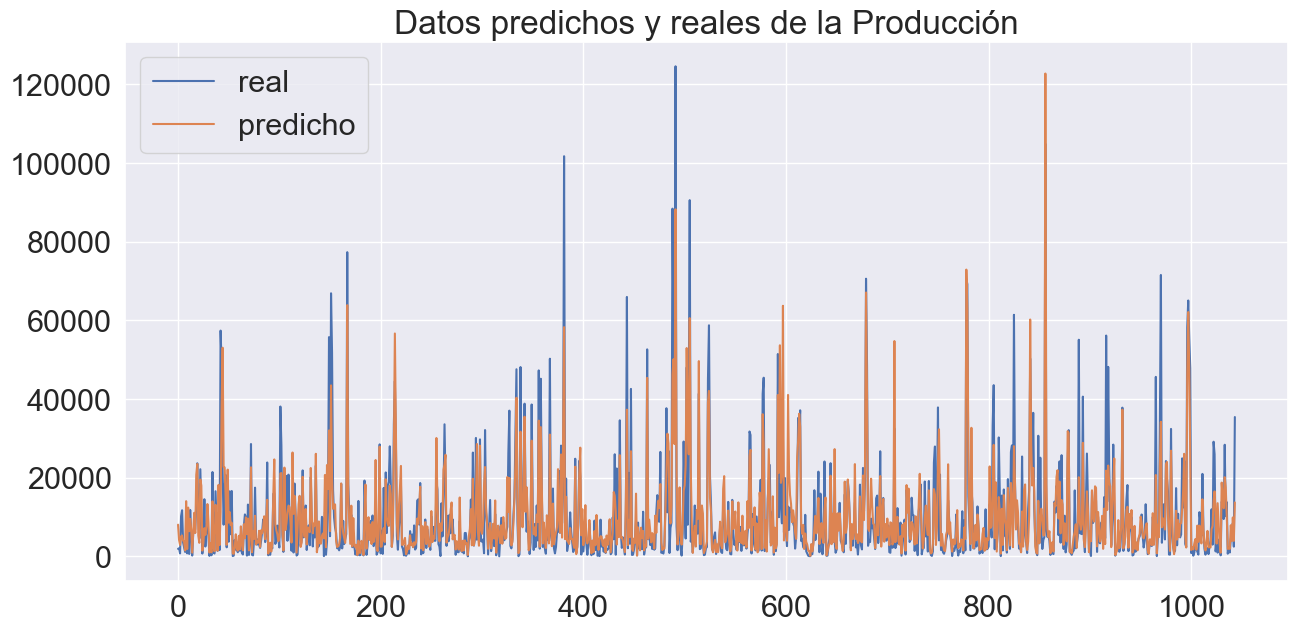

In [322]:
x_ax = range(len(y_test))
plt.figure(figsize=(15, 7))
plt.plot(x_ax, y_test, label="real")
plt.plot(x_ax, y_pred, label="predicho")
plt.title("Datos predichos y reales de la Producción")
plt.legend()
plt.show()

In [324]:
a = pd.concat([dfy_train, dfy_test])
rmse/np.std(a)

PRODUCCION   0.53
dtype: float64

In [163]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter space to search over
param_grid = {
    #'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.75, 0.9],
    'colsample_bytree': [0.75, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


# Define a list to store the test MSE for each model
test_rmse_list = []

# Loop over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    # Define the XGB model with the current set of hyperparameters
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42, 
        **params
    )
    
    # Fit the XGB model to the training data
    xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=10,
    verbose=False
    )
    
    # Predict on the test data and calculate the test MSE
    y_pred = xgb_model.predict(X_test)
    test_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Append the test MSE to the list
    test_rmse_list.append(test_rmse)

# Find the hyperparameters that resulted in the lowest test MSE
best_params = list(ParameterGrid(param_grid))[test_rmse_list.index(min(test_rmse_list))]
best_test_rmse = min(test_rmse_list)

# Print the best hyperparameters and the corresponding test MSE
print(f"Best hyperparameters: {best_params}")
print(f"Best test MSE: {best_test_rmse}")

Best hyperparameters: {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.75}
Best test MSE: 7214.300701359


Sorprendentemente peor que nuestra estimación inicial... nos quedaremos con ella

### 4.3. Predicciones

In [192]:
dfy_test = dfy_test.reset_index()
dfy_test['PRED']= pd.concat([pd.Series(y_pred)], axis=1)

In [204]:
np.sqrt(np.mean(abs(dfy_test['PRODUCCION'] - dfy_test['PRED'])**2))

7025.319250597161

In [325]:
bst = XGBRegressor(gamma=0.25, reg_lambda=10, subsample=0.9)#, learning_rate=0.05)


# Split the data into training and testing sets
dfy_train = dfy.loc[dfy['year'] < 2022]
dfy_test = dfy.loc[dfx['year'] == 2022]
dfx_train = dfx.loc[dfx['year'] < 2022]
dfx_test = dfx.loc[dfx['year'] == 2022]
dfy_train = dfy_train.drop(columns=['year'])
dfy_test = dfy_test.drop(columns=['year'])
dfx_train = dfx_train.drop(columns=['year'])
dfx_test = dfx_test.drop(columns=['year'])
# Split the data into training and testing sets
X_train = dfx_train
X_test = dfx_test
y_train = dfy_train.PRODUCCION
y_test = dfy_test.PRODUCCION


# Fit the model on the training data
bst.fit(X_train, y_train)

# Predict on the testing data
y_pred = bst.predict(X_test)

In [326]:
y_pred

array([ 6779.112 ,  2391.3875,  1827.9841, ..., 19473.643 ,  4200.1665,
        3485.3154], dtype=float32)

In [346]:
df = r'C:\Users\mromg\OneDrive\Documentos\MEGA\MEGA\Manu\UCM\UH_2023_TRAIN.txt'
df = pd.read_csv(df, sep='|')

In [347]:
na_indices = df.index[(df['PRODUCCION'].isna()) & (df['CAMPAÑA'] == 22)]

# Substitute NA values with corresponding elements from the array
df.loc[na_indices, 'PRODUCCION'] = y_pred[:len(na_indices)]

# Print the updated DataFrame
print(df)

      CAMPAÑA  ID_FINCA  ID_ZONA  ID_ESTACION ALTITUD  VARIEDAD  MODO  TIPO  \
0          14     76953      515            4     660        26     2     0   
1          14     84318      515            4     660        26     2     0   
2          14     85579      340            4     520        32     2     0   
3          14     69671      340            4     520        32     2     0   
4          14     14001      852           14     NaN        81     1     0   
...       ...       ...      ...          ...     ...       ...   ...   ...   
9596       22     37461      239            6     700        52     2     0   
9597       22     58769      239            6     700        32     2     0   
9598       22     58769      239            6     700        59     2     0   
9599       22     88928      239            6     700        40     2     0   
9600       22     88928      239            6     700        52     2     0   

      COLOR  SUPERFICIE  PRODUCCION  
0         1  

In [348]:
df['PRODUCCION'].isna().sum()

0

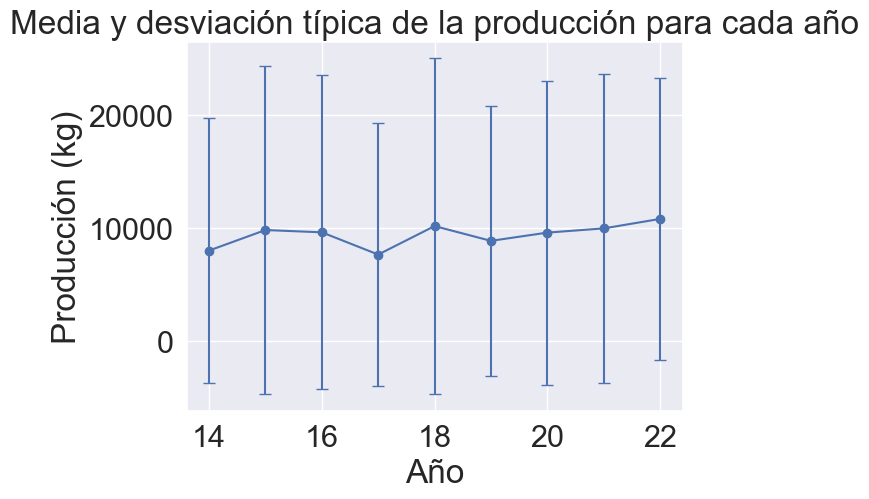

In [349]:
results = pd.DataFrame(columns=['year', 'mean', 'std'])

# Loop over the years
for i in range(14, 23):
    # Calculate standard deviation and mean for year
    std = df.loc[df['CAMPAÑA'] == i]['PRODUCCION'].std()
    mean = df.loc[df['CAMPAÑA'] == i]['PRODUCCION'].mean()
    
    # Add the results to the DataFrame
    results = results.append({'year': i, 'mean': mean, 'std': std}, ignore_index=True)

# Plot the results
plt.errorbar(results['year'], results['mean'], yerr=results['std'], fmt='o-', capsize=4)
plt.xlabel('Año')
plt.ylabel('Producción (kg)')
plt.title('Media y desviación típica de la producción para cada año')
plt.show()

In [350]:
df

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00
...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.68,8597.55
9597,22,58769,239,6,700,32,2,0,1,4.25,3473.77
9598,22,58769,239,6,700,59,2,0,1,4.07,19473.64
9599,22,88928,239,6,700,40,2,0,1,4.57,4200.17


In [351]:
df = df.loc[df["CAMPAÑA"] == 22]
df = df.drop(columns=['CAMPAÑA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD'])
df

,ID_FINCA,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
8526,48626,32,2,0,1,3.75,6779.11
8527,47921,32,2,0,1,7.37,2391.39
8528,5696,59,1,0,1,7.62,1827.98
8529,98814,32,2,0,1,3.33,13499.27
8530,98814,40,2,0,1,2.77,34471.27
...,...,...,...,...,...,...,...
9596,37461,52,2,0,1,3.68,8597.55
9597,58769,32,2,0,1,4.25,3473.77
9598,58769,59,2,0,1,4.07,19473.64
9599,88928,40,2,0,1,4.57,4200.17


In [354]:
df['PRODUCCION'] = np.round(df['PRODUCCION'], 2)

In [357]:
df.to_csv('OGAS.txt', sep="|", index=False, header=False)